# Unsupervised Learning: Trade&Ahead

**Marks: 60**

### Context

The stock market has consistently proven to be a good place to invest in and save for the future. There are a lot of compelling reasons to invest in stocks. It can help in fighting inflation, create wealth, and also provides some tax benefits. Good steady returns on investments over a long period of time can also grow a lot more than seems possible. Also, thanks to the power of compound interest, the earlier one starts investing, the larger the corpus one can have for retirement. Overall, investing in stocks can help meet life's financial aspirations.

It is important to maintain a diversified portfolio when investing in stocks in order to maximise earnings under any market condition. Having a diversified portfolio tends to yield higher returns and face lower risk by tempering potential losses when the market is down. It is often easy to get lost in a sea of financial metrics to analyze while determining the worth of a stock, and doing the same for a multitude of stocks to identify the right picks for an individual can be a tedious task. By doing a cluster analysis, one can identify stocks that exhibit similar characteristics and ones which exhibit minimum correlation. This will help investors better analyze stocks across different market segments and help protect against risks that could make the portfolio vulnerable to losses.


### Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired you as a Data Scientist and provided you with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned you the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

### Data Dictionary

- Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- Company: Name of the company
- GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- Current Price: Current stock price in dollars
- Price Change: Percentage change in the stock price in 13 weeks
- Volatility: Standard deviation of the stock price over the past 13 weeks
- ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- Cash Ratio: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)
- Net Income: Revenues minus expenses, interest, and taxes (in dollars)
- Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- Estimated Shares Outstanding: Company's stock currently held by all its shareholders
- P/E Ratio: Ratio of the company's current stock price to the earnings per share 
- P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)

## Importing necessary libraries and data

In [1]:
# set warnings
import warnings
warnings.filterwarnings("ignore")

# import libraries for data manipulation
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import statsmodels.stats.api as sms

# import libraries for hypothesis testing
from scipy.stats import (
    zscore,
)

# import libraries for data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.compat import lzip

# For data preprocessing
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import (
    OneHotEncoder,
    PolynomialFeatures,
    StandardScaler,
    MinMaxScaler,
)

# To build cluster model (unsupervised learning)
from sklearn.decomposition import PCA
from scipy.spatial.distance import (
    cdist,
    pdist
)
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering
)
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import (
    KElbowVisualizer, 
    SilhouetteVisualizer
)
from scipy.cluster.hierarchy import (
    cophenet, 
    dendrogram, 
    linkage # linkage has 'average' 'complete' 'ward' hyperparameters
)
from sklearn.manifold import TSNE # alternate dimension reduction technique other than PCA, but only used for visualization

## To get diferent metric scores
from sklearn import metrics
from sklearn.metrics import (
    silhouette_score
)

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)                                                 

## Data Overview

In [2]:
data = pd.read_csv('stock_data.csv')
df = data.copy()

In [3]:
df.head()

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,AAL,American Airlines Group,Industrials,Airlines,42.349998,9.999995,1.687151,135,51,-604000000,7610000000,11.39,6.681299e+08,3.718174,-8.784219
1,ABBV,AbbVie,Health Care,Pharmaceuticals,59.240002,8.339433,2.197887,130,77,51000000,5144000000,3.15,1.633016e+09,18.806350,-8.750068
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,44.910000,11.301121,1.273646,21,67,938000000,4423000000,2.94,1.504422e+09,15.275510,-0.394171
3,ADBE,Adobe Systems Inc,Information Technology,Application Software,93.940002,13.977195,1.357679,9,180,-240840000,629551000,1.26,4.996437e+08,74.555557,4.199651
4,ADI,"Analog Devices, Inc.",Information Technology,Semiconductors,55.320000,-1.827858,1.701169,14,272,315120000,696878000,0.31,2.247994e+09,178.451613,1.059810


- `Security` will be dropped out throughout the analysis since we already have `Ticker_Symbol`

In [4]:
df.shape

(340, 15)

In [5]:
# fixing column names
df.columns = [c.replace(" ", "_") for c in df.columns]

In [6]:
df.drop(["Security"], axis=1, inplace=True)

In [7]:
for feature in df.columns: # Loop through all columns in the dataframe
    if df[feature].dtype == 'object': # Only apply for columns with categorical strings
        df[feature] = pd.Categorical(df[feature])# Replace strings with an integer

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Ticker_Symbol                 340 non-null    category
 1   GICS_Sector                   340 non-null    category
 2   GICS_Sub_Industry             340 non-null    category
 3   Current_Price                 340 non-null    float64 
 4   Price_Change                  340 non-null    float64 
 5   Volatility                    340 non-null    float64 
 6   ROE                           340 non-null    int64   
 7   Cash_Ratio                    340 non-null    int64   
 8   Net_Cash_Flow                 340 non-null    int64   
 9   Net_Income                    340 non-null    int64   
 10  Earnings_Per_Share            340 non-null    float64 
 11  Estimated_Shares_Outstanding  340 non-null    float64 
 12  P/E_Ratio                     340 non-null    floa

In [9]:
df.duplicated().sum()

0

In [10]:
df.isnull().sum()

Ticker_Symbol                   0
GICS_Sector                     0
GICS_Sub_Industry               0
Current_Price                   0
Price_Change                    0
Volatility                      0
ROE                             0
Cash_Ratio                      0
Net_Cash_Flow                   0
Net_Income                      0
Earnings_Per_Share              0
Estimated_Shares_Outstanding    0
P/E_Ratio                       0
P/B_Ratio                       0
dtype: int64

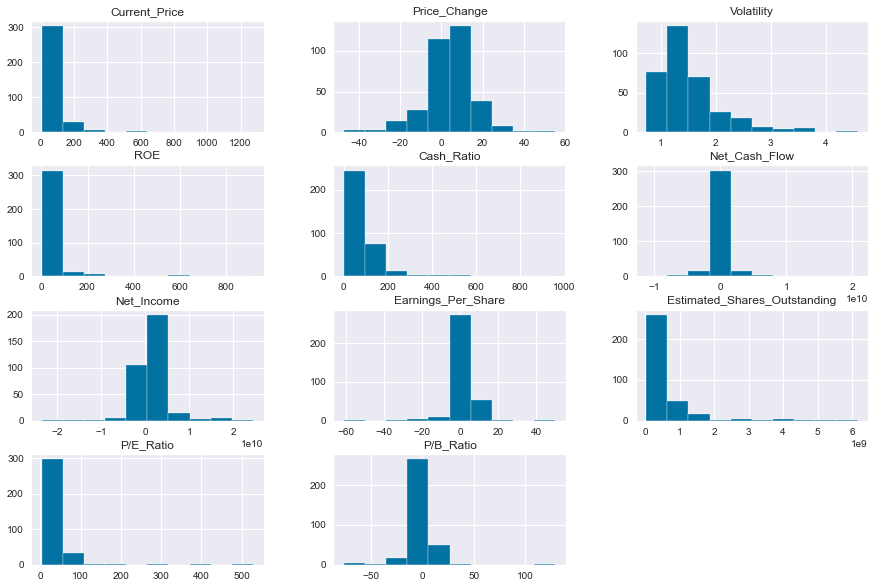

In [11]:
sns.set_style("darkgrid")
df.hist(figsize=(15, 10))
plt.show()

In [12]:
cols = df.columns

for col in cols:
    print("Unique values in the column '{}' are \n\n".format(col), df[col].unique())
    print("-" * 100)

Unique values in the column 'Ticker_Symbol' are 

 ['AAL', 'ABBV', 'ABT', 'ADBE', 'ADI', ..., 'YHOO', 'YUM', 'ZBH', 'ZION', 'ZTS']
Length: 340
Categories (340, object): ['AAL', 'ABBV', 'ABT', 'ADBE', ..., 'YUM', 'ZBH', 'ZION', 'ZTS']
----------------------------------------------------------------------------------------------------
Unique values in the column 'GICS_Sector' are 

 ['Industrials', 'Health Care', 'Information Technology', 'Consumer Staples', 'Utilities', ..., 'Real Estate', 'Materials', 'Consumer Discretionary', 'Energy', 'Telecommunications Services']
Length: 11
Categories (11, object): ['Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', ..., 'Materials', 'Real Estate', 'Telecommunications Services', 'Utilities']
----------------------------------------------------------------------------------------------------
Unique values in the column 'GICS_Sub_Industry' are 

 ['Airlines', 'Pharmaceuticals', 'Health Care Equipment', 'Application Software', 'Semi

In [13]:
df.describe(include='all')

,Ticker_Symbol,GICS_Sector,GICS_Sub_Industry,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio
count,340,340,340,340.000000,340.000000,340.000000,340.000000,340.000000,3.400000e+02,3.400000e+02,340.000000,3.400000e+02,340.000000,340.000000
unique,340,11,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,AAL,Industrials,Oil & Gas Exploration & Production,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,53,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,80.862345,4.078194,1.525976,39.597059,70.023529,5.553762e+07,1.494385e+09,2.776662,5.770283e+08,32.612563,-1.718249
std,NaN,NaN,NaN,98.055086,12.006338,0.591798,96.547538,90.421331,1.946365e+09,3.940150e+09,6.587779,8.458496e+08,44.348731,13.966912
min,NaN,NaN,NaN,4.500000,-47.129693,0.733163,1.000000,0.000000,-1.120800e+10,-2.352800e+10,-61.200000,2.767216e+07,2.935451,-76.119077
25%,NaN,NaN,NaN,38.555000,-0.939484,1.134878,9.750000,18.000000,-1.939065e+08,3.523012e+08,1.557500,1.588482e+08,15.044653,-4.352056
50%,NaN,NaN,NaN,59.705000,4.819505,1.385593,15.000000,47.000000,2.098000e+06,7.073360e+08,2.895000,3.096751e+08,20.819876,-1.067170
75%,NaN,NaN,NaN,92.880001,10.695493,1.695549,27.000000,99.000000,1.698108e+08,1.899000e+09,4.620000,5.731175e+08,31.764755,3.917066


#### Observations:

- Dataset is the size of 15 columns and 340 entries.
- 3 of the columns are categorical, i.e. `Ticker_Symbol`, `GICS_Sector`, and `GICS_Sub_Industry`.
- The rest of the variables are integers and floating numbers.
- No duplicated values
- No missing values
- No notable error in the dataset but a lot of outliers.
- There are a total of 340 unique `Ticker_Symbol` which are the unique abbreviation for the respective company's stock.
- 11 unique `GICS_Sector` and 53 of the company are from industrials sector.
- 104 unique `GICS_Sub_Industry` and 16 of them are Oil & Gas Exploration & Production.
- The `Current_Price` average among all the stocks is \$80.86 but the median is at \$59.71. It ranges between \$4.50 to \$1275.
- The `Price_Change` average over the past 13 weeks is \$4.08, close to the median of \$4.82. It ranges between -\$47.13 to \$55.05.
- The `Volatility` in the past 13 weeks averaged at 1.52, close to the median of 1.39. It ranges between 0.73 to 4.58.
- `ROE` has an average of 39.60, higher than the median of 15. Ranging between 1 to 917.
- `Cash_Ratio` ranges between 0 to 958, mean of 70.02 and median of 47.
- `Net_Cash_Flow` and `Net_Income` ranges from very small to very large values\
- `Earnings_Per_Share` has a minimum of -\$61.2 to a maximum of \$50.09.
- `Estimated_Shares_Outstanding` are of very large values.
- The `P/E_Ratio` has a mean of 32.61 and a median of 20.82. Ranging between 2.93 to 528.04.
- The `P/B_Ratio` has a mean of -1.72 amd a median of -1.07. Ranging between -76.12 to 129.06.


## Exploratory Data Analysis (EDA)

### Univariate Analysis

In [14]:
# a function that plots histogram and boxplot together as one output.
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):

    # creating the 2 subplots
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.15, 0.85)},
        figsize=figsize,
    )  
    
    # boxplot will be created and a diamiond will indicate the mean value of the column
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, 
        showmeans=True, meanprops={"marker":"D","markerfacecolor":"red", "markeredgecolor":"red"},
        color='lightblue'
    )  
    
    # For histogram
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, color='lightblue'
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, color='lightblue'
    )  
    
    # Add a vertical dashed line indicating the mean value to the histogram
    ax_hist2.axvline(
        data[feature].mean(), color="red", linestyle="--"
    )
    
    # Add a vertical line indicating the median value to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="red", linestyle="-"
    )


In [15]:
# function to create labeled barplots for categorical variables
def labeled_barplot(data, feature, perc=False, n=None):
    """
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    
    # set size of figure based on top n catogory levels
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    
    # the barplot
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="pastel",
        order=data[feature].value_counts().index[:n],
    )
    
    # To compute the percentages/counts that will be labelled in the barplot
    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot
        
        # annotate the percentage on the barplot
        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        ) # for-loop-ends-here 

    plt.show()

In [18]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

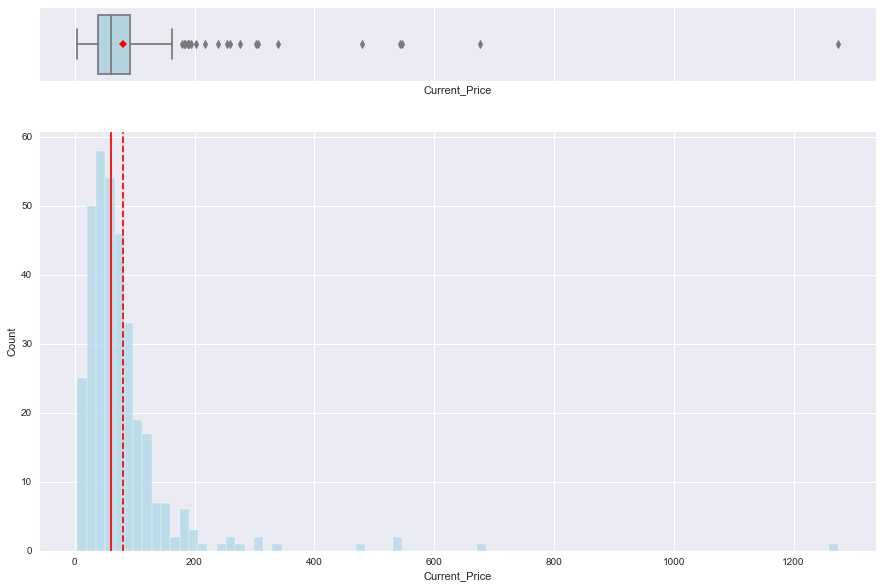

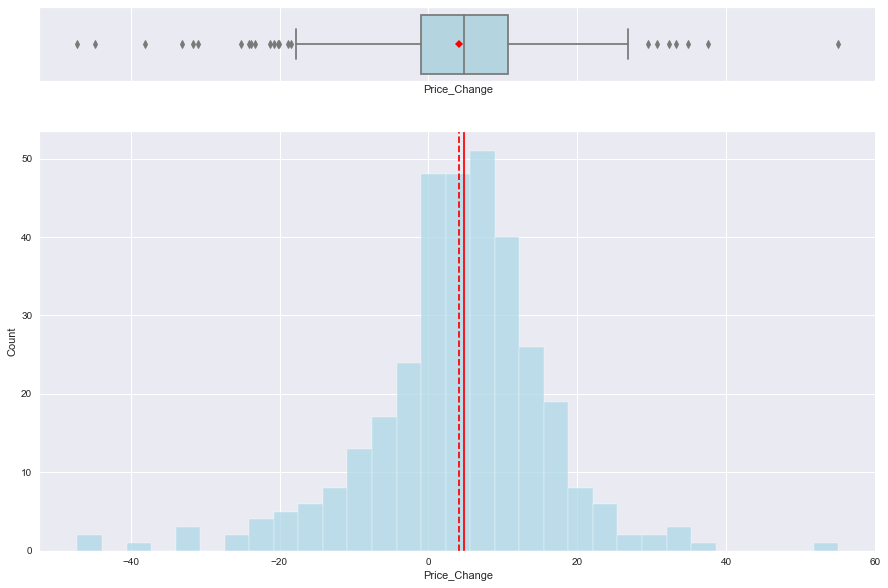

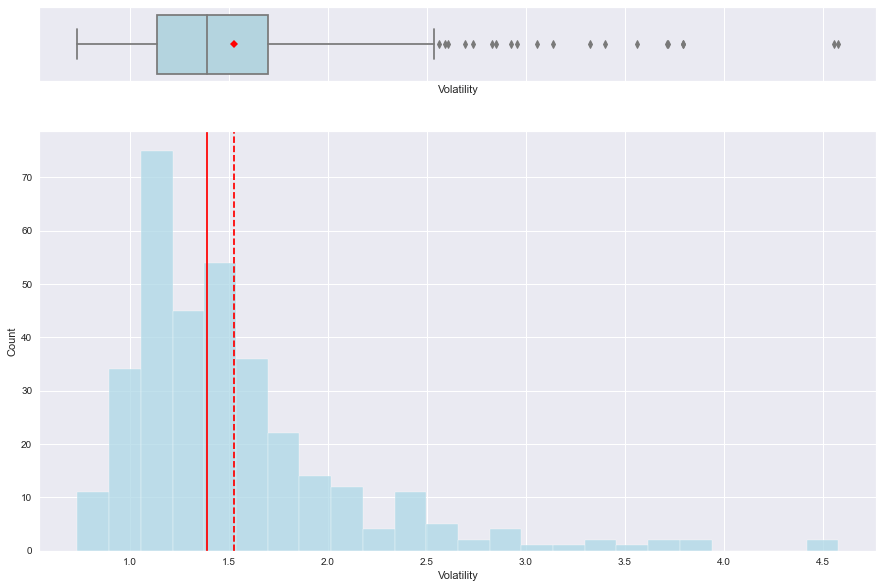

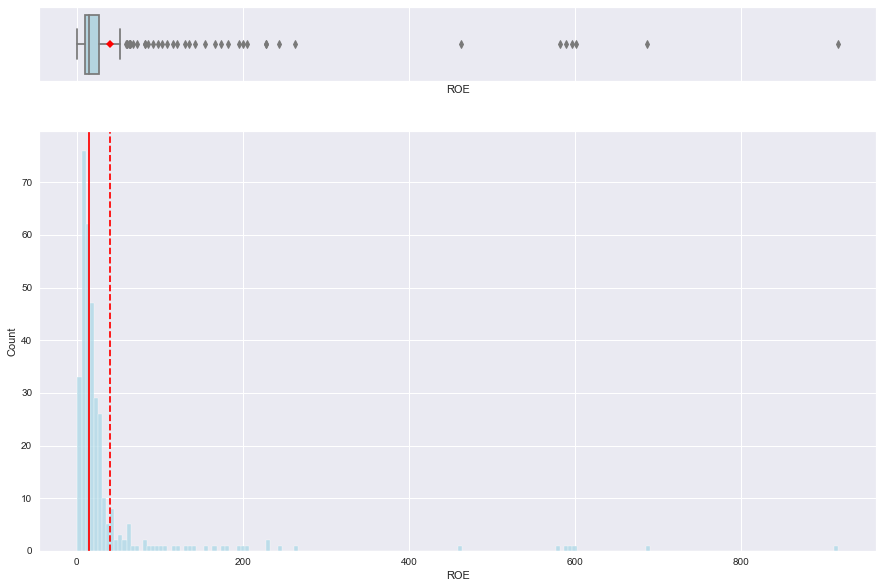

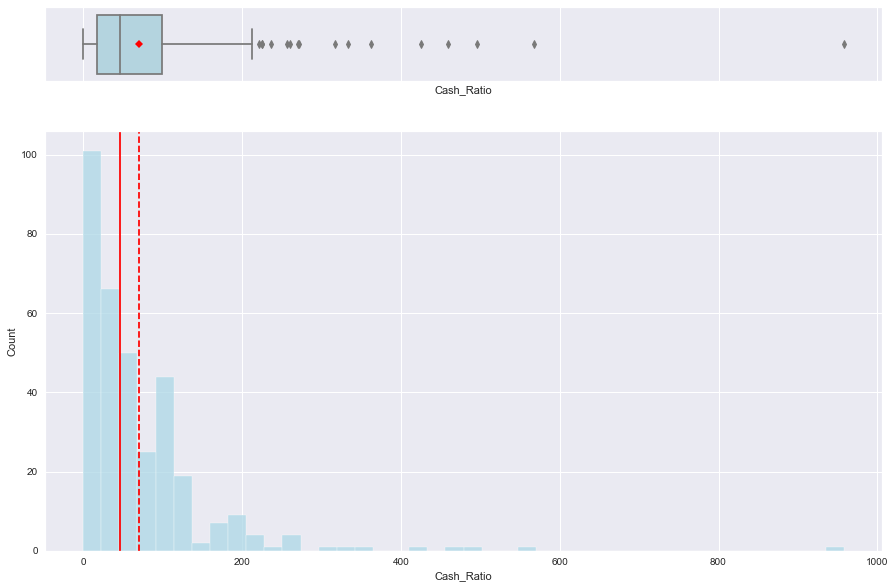

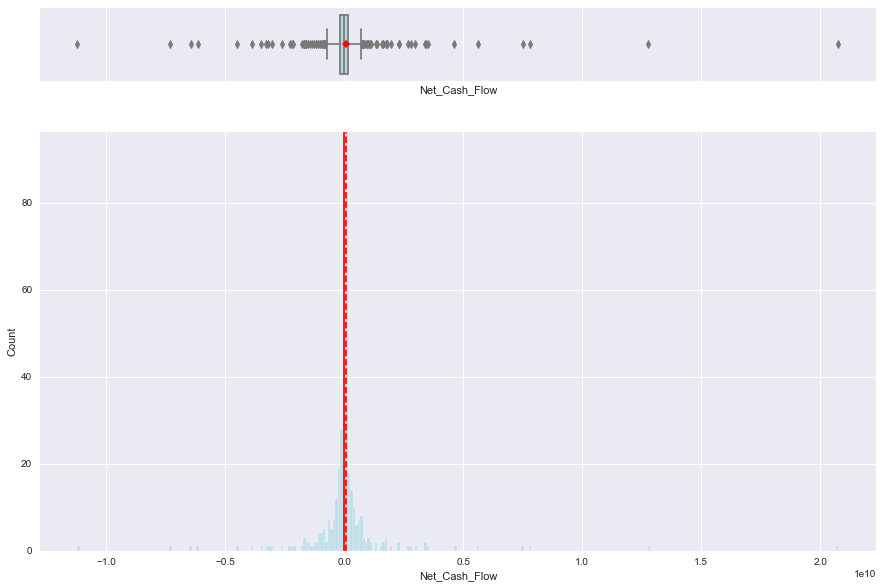

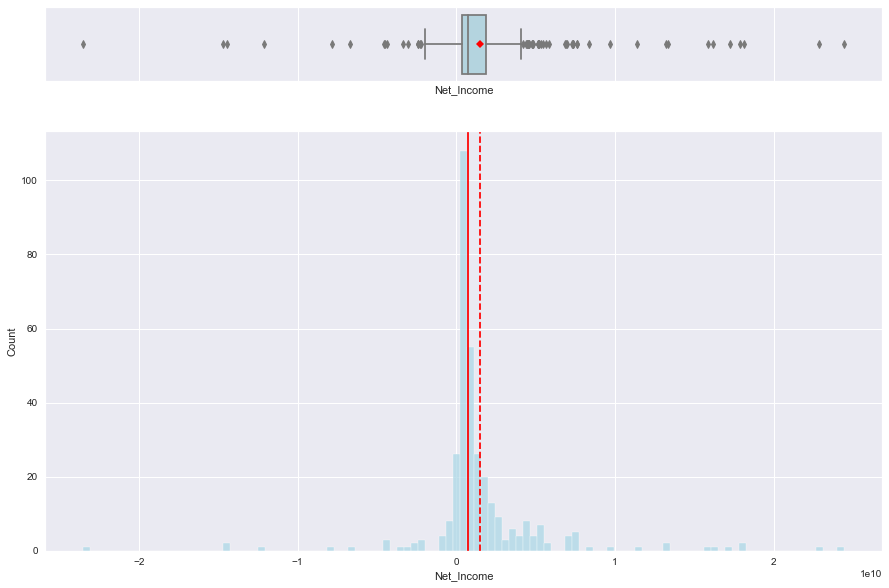

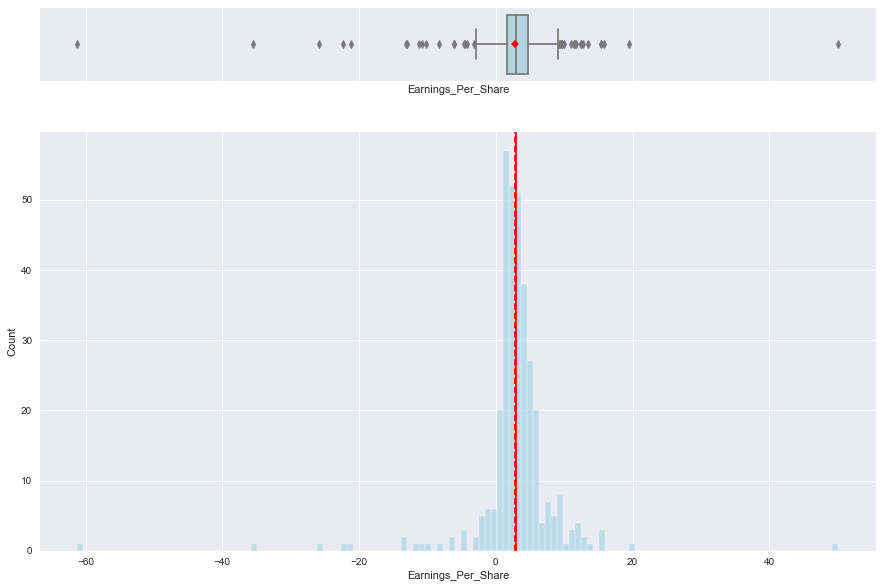

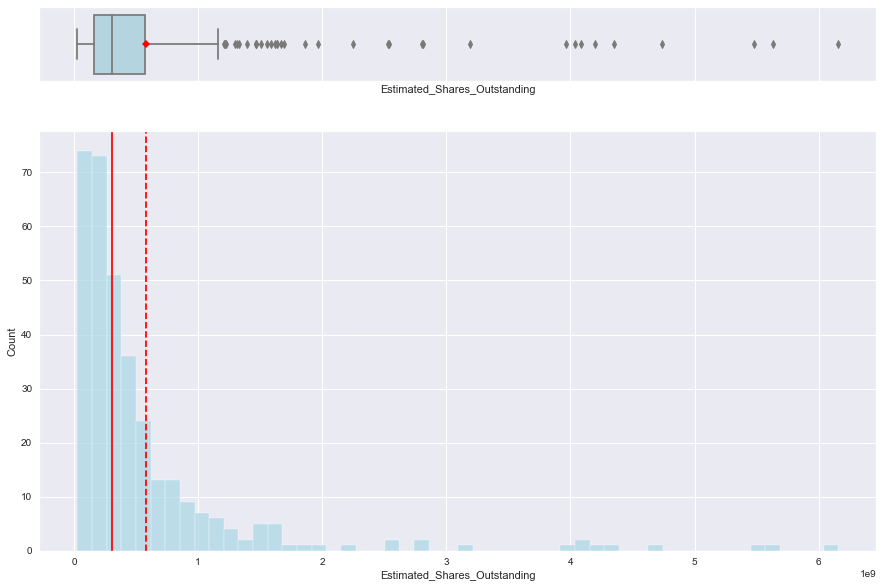

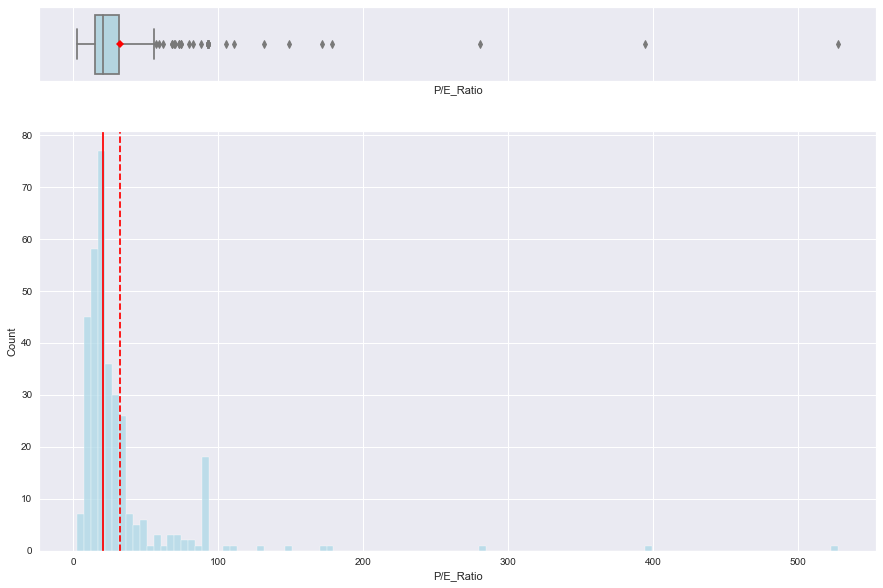

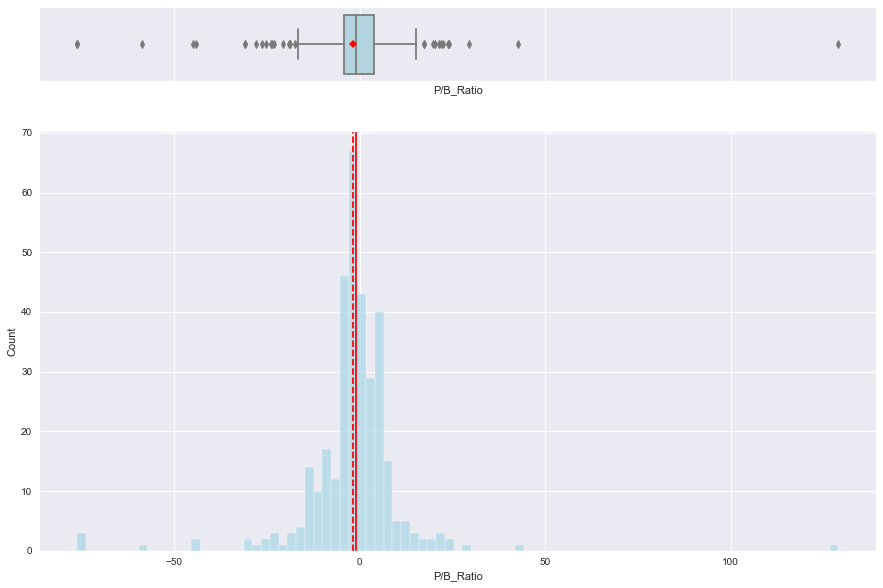

In [19]:
for item in num_col:
    histogram_boxplot(df, item)

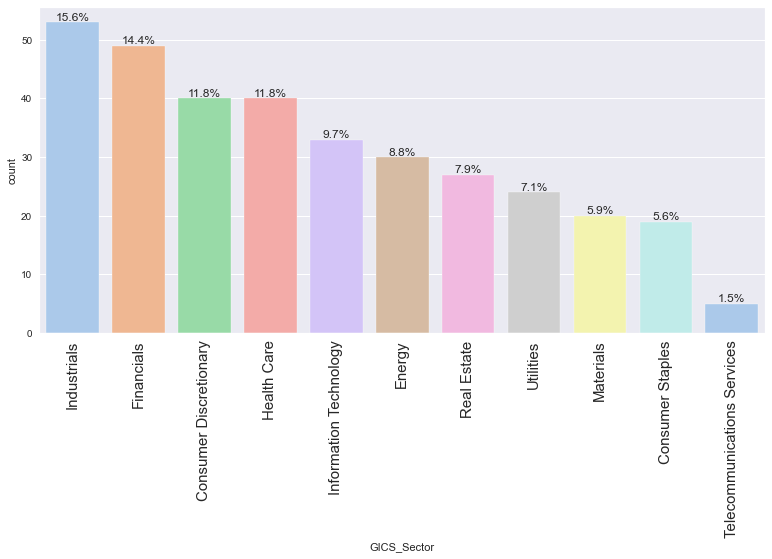

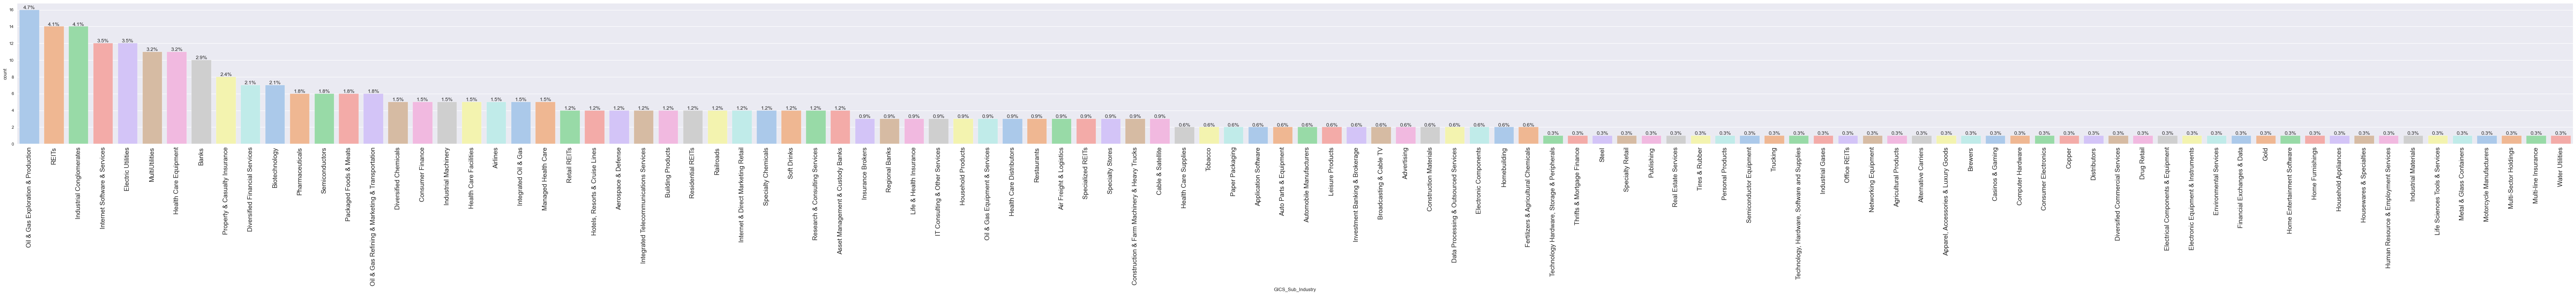

In [20]:
labeled_barplot(df, 'GICS_Sector', perc=True, n=None)
labeled_barplot(df, 'GICS_Sub_Industry', perc=True, n=None)

#### Observations:
- (1) `Current_Price` is heavily right-skewed. 
- `Price_Change` is somewhat normal but heavy-tailed on both side.
- `Volatility` is right-skewed as expected.
- `ROE` is heavily right-skewed, similar to `Cash_Ratio`
- `Net_Cash_Flow` centred around 0 with very small and very large outliers. Similarly for `Net_Income`, `Earning_Per_Share` and `P/B_Ratio`.
- `Estimated_Shares_Outstanding` and `P/E_Ratio` is heavily right-skewed.
- Industrial sector cover 15.6% of the whole. Followed by financial sector with 14.4%. Consumer Discretionary and Health Care sector has the same number of company, 11.8% of the total respectively.
- The top 3 subsector are found to be Oil & Gas, REITs, and Industrial Conglomerates.

### Bivariate Analysis

Starting off with correlation matrix

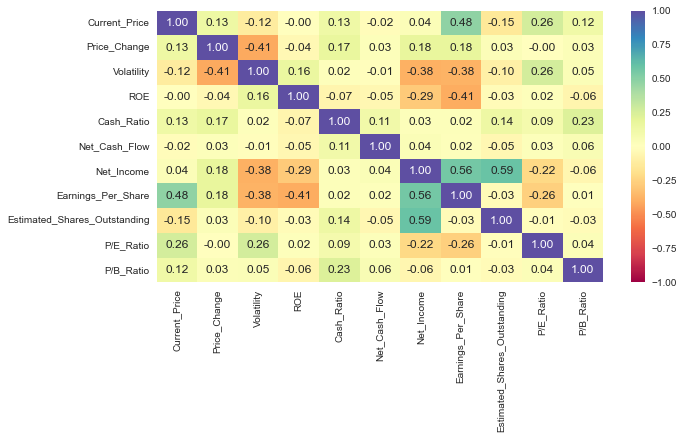

In [21]:
cols_list = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(10, 5))
sns.heatmap(
    df[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
) ## Complete the code to find the correlation between the variables
plt.show()

#### Observations:
(3)
- `Net_Income` with `Earnings_Per_Share` and `Estimated_Shares_Outstanding` is moderate positively correlated respectively.
- `Current_Price` and `Earnings_Per_Share` is also moderate positively correlated.
- `Volatility` and `Price_Change`, `Net_Income`, `Earnings_Per_Share` is moderate negatively correlated respectively.
- Same for `Earnings_Per_Share` and `ROE` being moderate negatively correlated.


We now look at the relationships of the numerical variables with variable `GICS_Sector`

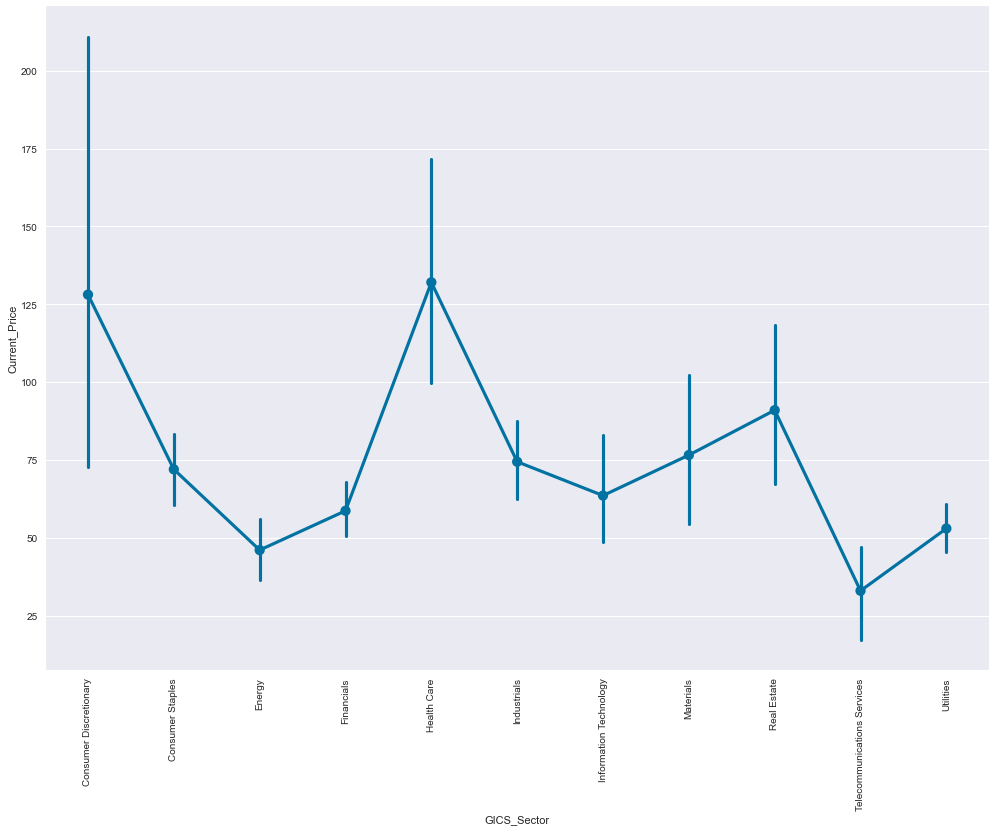

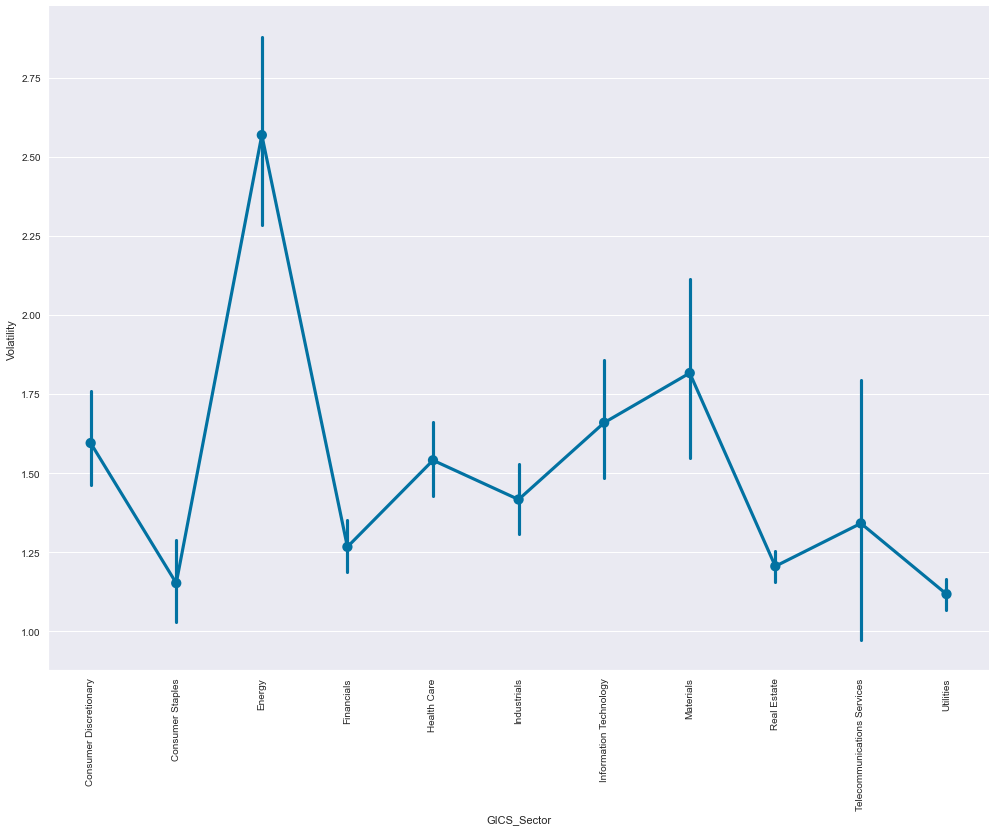

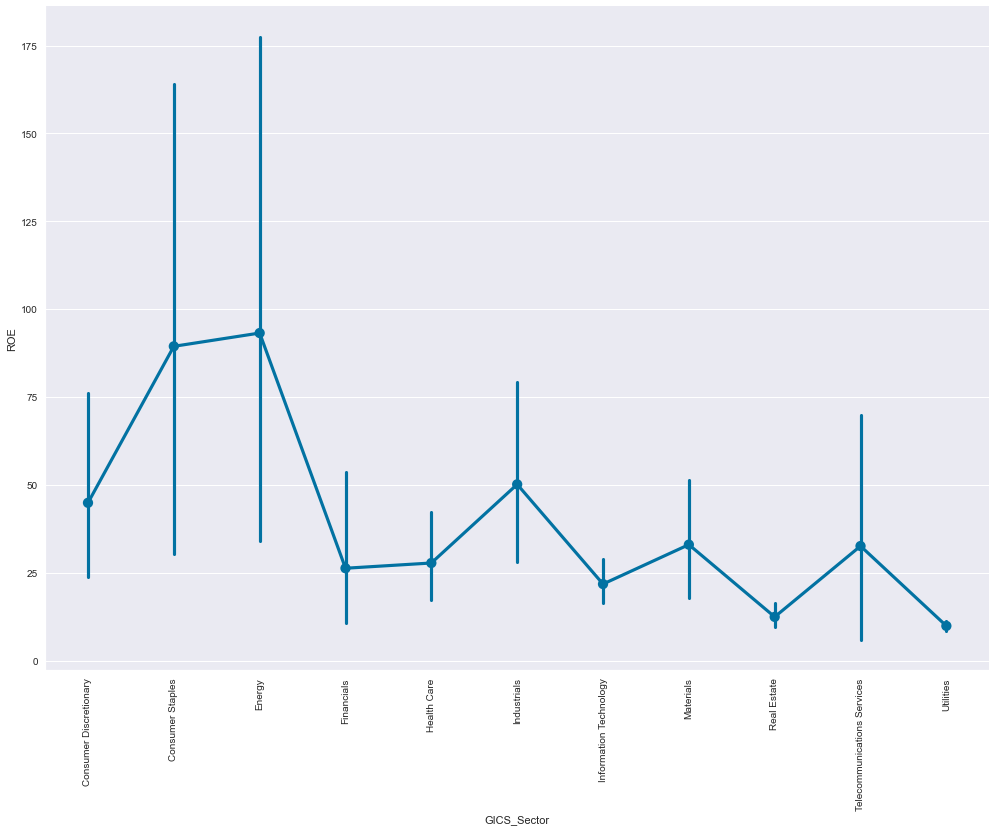

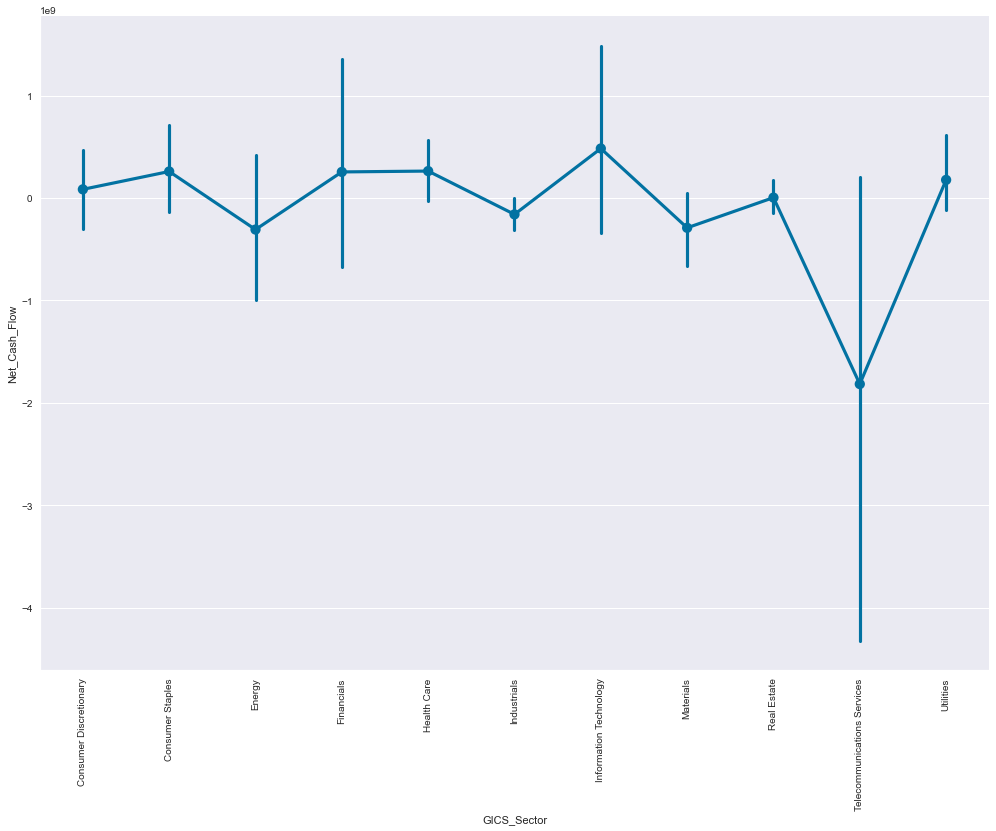

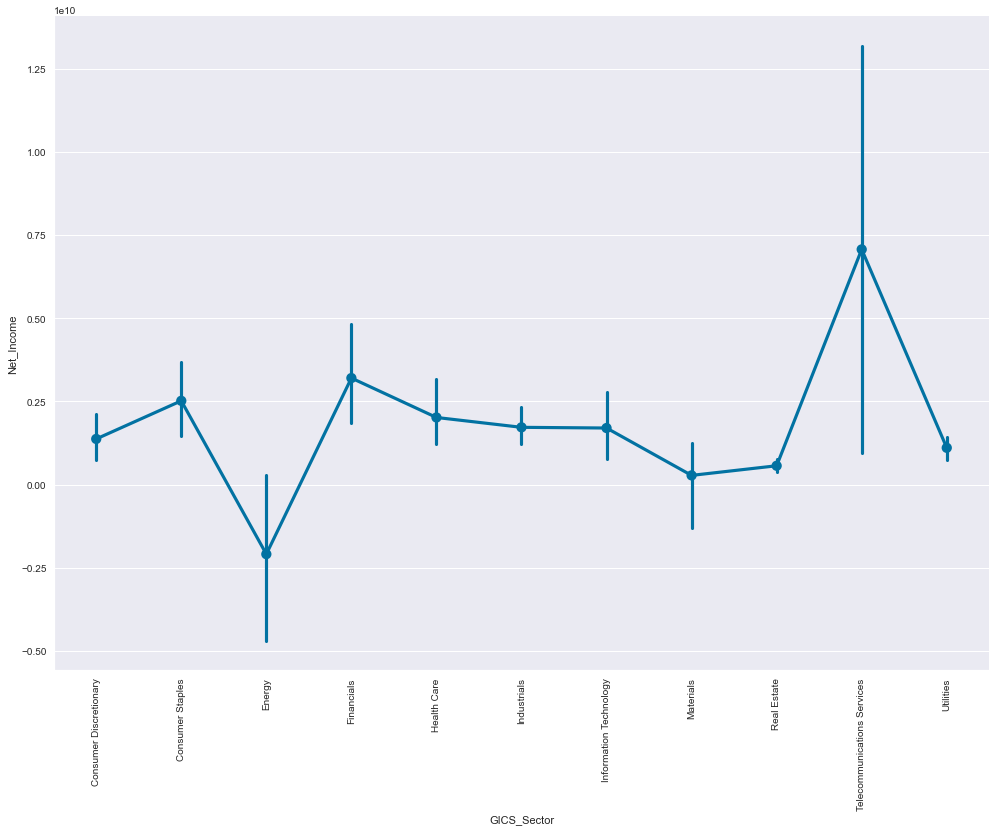

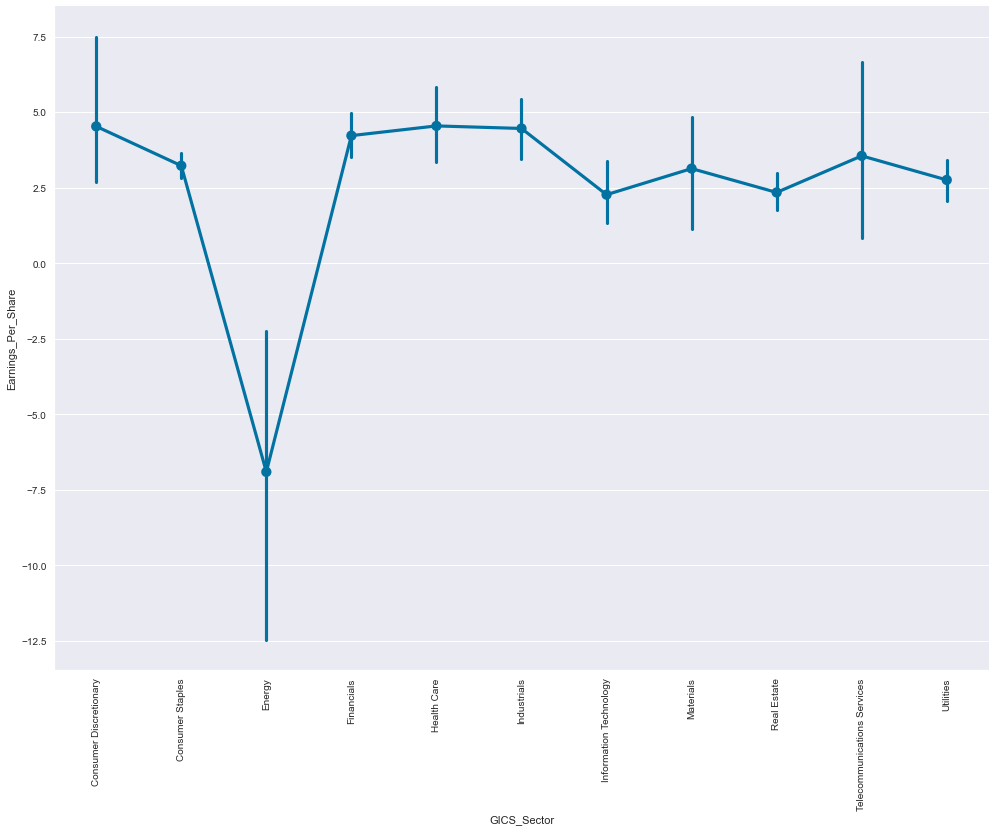

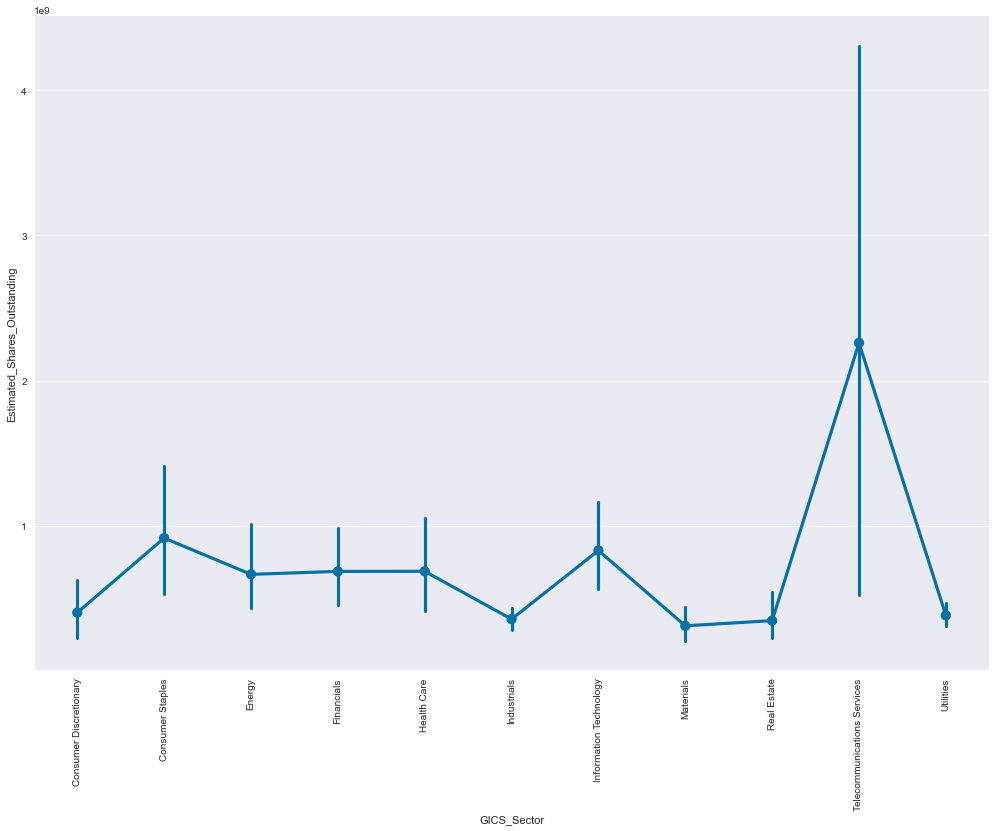

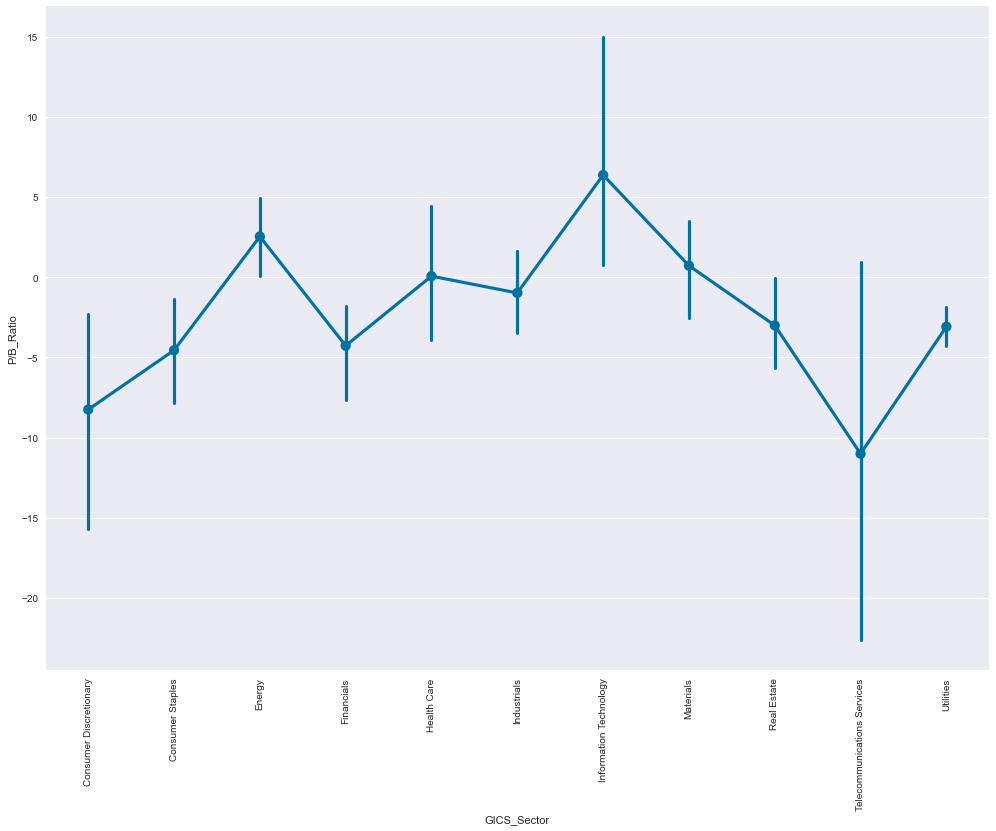

In [89]:
sns.catplot(data=df, kind='point', x="GICS_Sector", y="Current_Price",height=10, aspect=1.4)
plt.xticks(rotation=90)
plt.show()

sns.catplot(data=df, kind='point', x="GICS_Sector", y="Volatility",height=10, aspect=1.4)
plt.xticks(rotation=90)
plt.show()

sns.catplot(data=df, kind='point', x="GICS_Sector", y="ROE",height=10, aspect=1.4)
plt.xticks(rotation=90)
plt.show()

sns.catplot(data=df, kind='point', x="GICS_Sector", y="Net_Cash_Flow",height=10, aspect=1.4)
plt.xticks(rotation=90)
plt.show()

sns.catplot(data=df, kind='point', x="GICS_Sector", y="Net_Income",height=10, aspect=1.4)
plt.xticks(rotation=90)
plt.show()

sns.catplot(data=df, kind='point', x="GICS_Sector", y="Earnings_Per_Share",height=10, aspect=1.4)
plt.xticks(rotation=90)
plt.show()

sns.catplot(data=df, kind='point', x="GICS_Sector", y="Estimated_Shares_Outstanding",height=10, aspect=1.4)
plt.xticks(rotation=90)
plt.show()

sns.catplot(data=df, kind='point', x="GICS_Sector", y="P/B_Ratio",height=10, aspect=1.4)
plt.xticks(rotation=90)
plt.show()

#### Observations:

`Current_Price` 
- Health care sectors has the highest average current stock price. Followed by consumer discretionary sectors. Meanwhile telecommunication service sectors has the lowest average current stock price.

`Volatility`
- Energy sector has the highest average volatility over the past 13 weeks, which is expected.
- The averagely least volatile sector seems to be consumer staples and utilities sector.

`ROE`
- Energy and consumer staples sector has very high average ROE. While consumer discretionary and industrials sector are moderately high.
- The rest of the sector are more or less similar in average.

`Net_Cash_Flow`
- Net cash flow is somewhat similar across the sectors except for telecommunication services which has averagely low value.

`Net_Income`
- Telecommunication service has the highest average net income, contrary to energy sector which has the lowest average.
- While the rest of the sectors are similar in average.

`Earnings_Per_Share`
- Energy sector has the lowest average among all. The rest being similar.

`Estimated_Shares_Outstanding`
- Telecommunication service has the highest average among all. The rest being similar.

`P/B_Ratio`
- IT sector has the highest average P/B ratio. While telecommunication service has the lowest average.

### Some domain knowledge insights

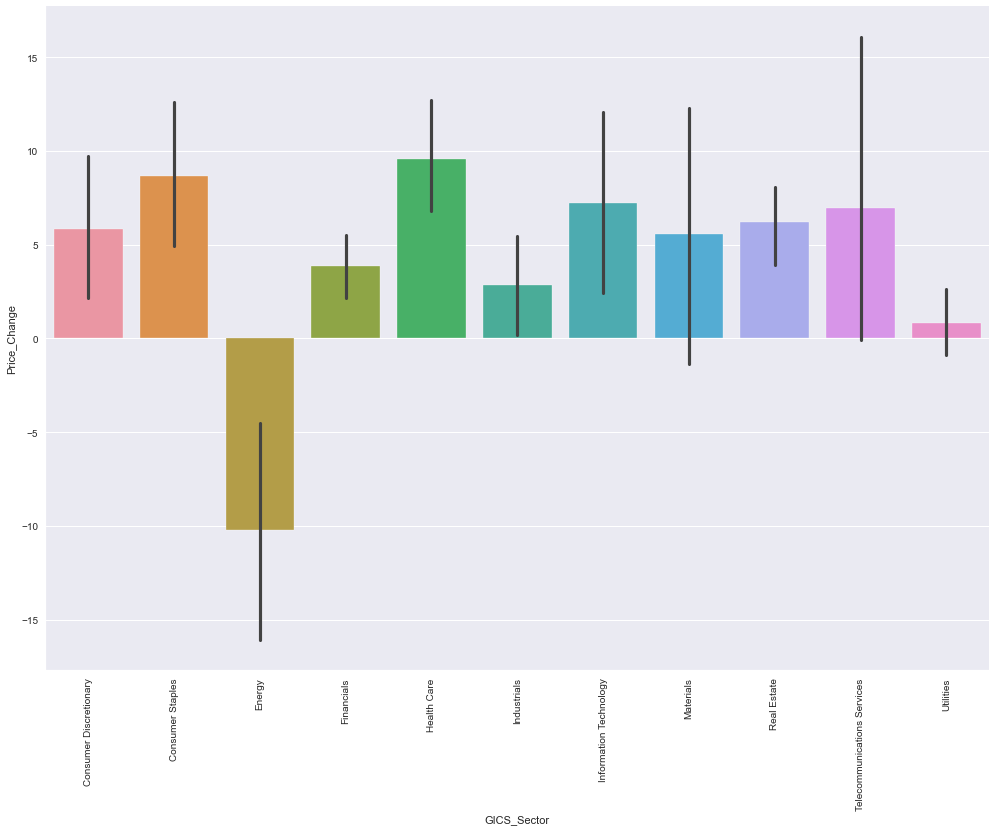

In [83]:
sns.catplot(data=df, kind='bar', x="GICS_Sector", y="Price_Change",height=10, aspect=1.4)
plt.xticks(rotation=90)
plt.show()

In [22]:
df.groupby('GICS_Sector')['Price_Change'].mean().sort_values(ascending=False)

GICS_Sector
Health Care                     9.585652
Consumer Staples                8.684750
Information Technology          7.217476
Telecommunications Services     6.956980
Real Estate                     6.205548
Consumer Discretionary          5.846093
Materials                       5.589738
Financials                      3.865406
Industrials                     2.833127
Utilities                       0.803657
Energy                        -10.228289
Name: Price_Change, dtype: float64

- (2) The stocks from Health Care sector seem to have a maximum of 9.58 price increase on average.

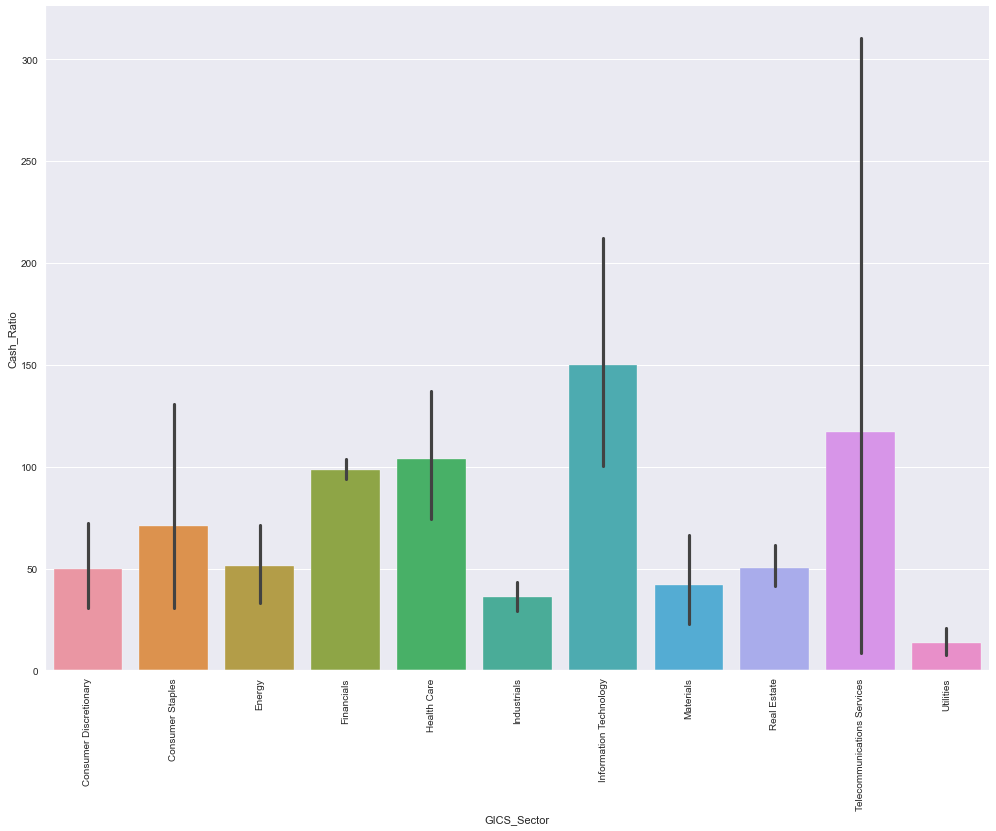

In [23]:
sns.catplot(data=df, kind='bar', x="GICS_Sector", y="Cash_Ratio",height=10, aspect=1.4)
plt.xticks(rotation=90)
plt.show()

In [87]:
df.groupby('GICS_Sector')['Cash_Ratio'].mean().sort_values(ascending=False)

GICS_Sector
Information Technology         149.818182
Telecommunications Services    117.000000
Health Care                    103.775000
Financials                      98.591837
Consumer Staples                70.947368
Energy                          51.133333
Real Estate                     50.111111
Consumer Discretionary          49.575000
Materials                       41.700000
Industrials                     36.188679
Utilities                       13.625000
Name: Cash_Ratio, dtype: float64

- (4) IT sector has the highest average cash ratio, followed by telecommunication services. The third is from health care sector followed by the fourth, financial sector.

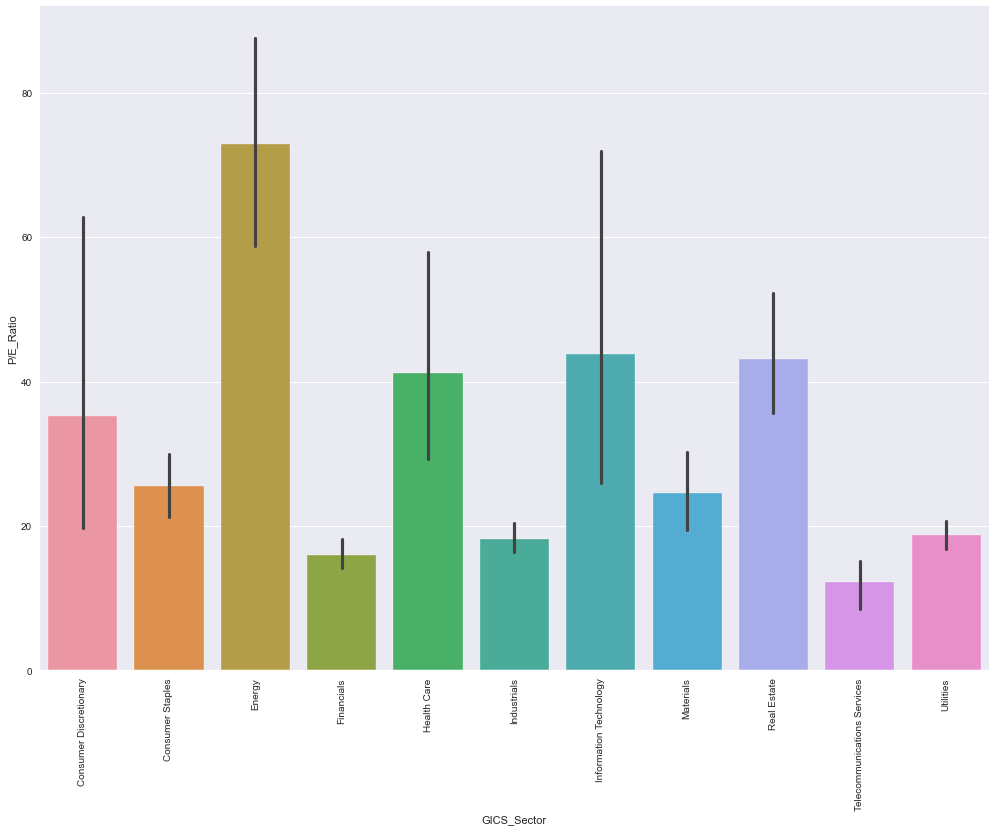

In [24]:
sns.catplot(data=df, kind='bar', x="GICS_Sector", y="P/E_Ratio",height=10, aspect=1.4)
plt.xticks(rotation=90)
plt.show()

In [88]:
df.groupby('GICS_Sector')['P/E_Ratio'].mean().sort_values(ascending=False)

GICS_Sector
Energy                         72.897709
Information Technology         43.782546
Real Estate                    43.065585
Health Care                    41.135272
Consumer Discretionary         35.211613
Consumer Staples               25.521195
Materials                      24.585352
Utilities                      18.719412
Industrials                    18.259380
Financials                     16.023151
Telecommunications Services    12.222578
Name: P/E_Ratio, dtype: float64

- (5) We see that energy sector has the highest P/E ratio among all, which is expected. In addition, IT, real estate and health care sectors are similarly high in P/E ratio.

## Data Preprocessing

#### Outlier treatment

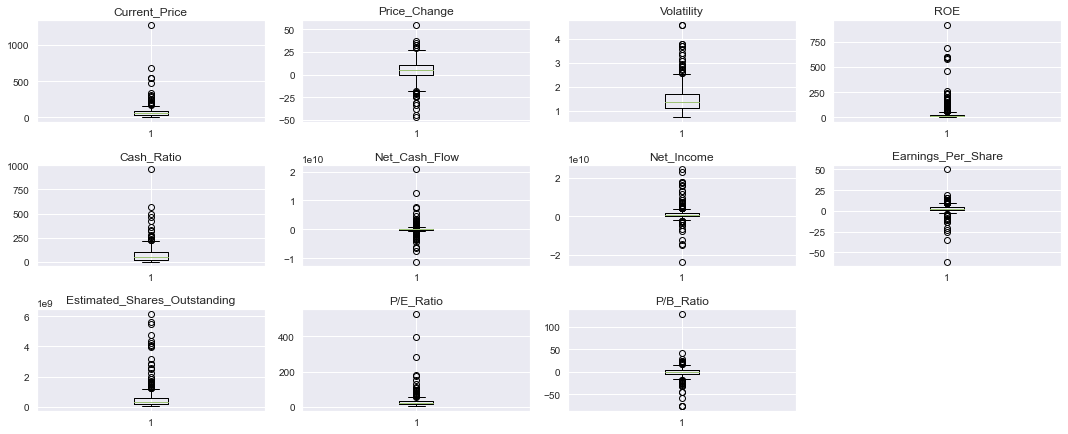

In [25]:
# outlier detection using boxplot
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()


plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(6, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

- All the outliers are seen to be true values hence no outlier treatment will be taken.

#### Scaling

In [26]:
# scaling the dataset before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [27]:
# checking the mean and standard deviation
np.mean(subset_scaled), np.std(subset_scaled)

(-1.852350714882614e-17, 1.0)

- The scaled dataset has mean of 0 and standard deviation of 1

In [28]:
# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

## K-means Clustering

Number of Clusters: 4 	Average Distortion: 2.1770961257432995
Number of Clusters: 5 	Average Distortion: 2.1272365937424977
Number of Clusters: 6 	Average Distortion: 2.072769863902725
Number of Clusters: 7 	Average Distortion: 2.015753461772297
Number of Clusters: 8 	Average Distortion: 1.9666321251346042
Number of Clusters: 9 	Average Distortion: 1.9317077850027702
Number of Clusters: 10 	Average Distortion: 1.8525037597648417
Number of Clusters: 11 	Average Distortion: 1.831436600556238
Number of Clusters: 12 	Average Distortion: 1.774405890184037


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

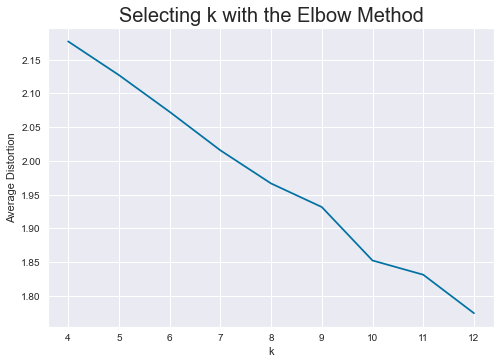

In [29]:
clusters = range(4, 13)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

For n_clusters = 4, silhouette score is 0.4495910932182279
For n_clusters = 5, silhouette score is 0.4314106887964818
For n_clusters = 6, silhouette score is 0.41236972535705346
For n_clusters = 7, silhouette score is 0.401235533083541
For n_clusters = 8, silhouette score is 0.4155198540218143
For n_clusters = 9, silhouette score is 0.31618329134627293


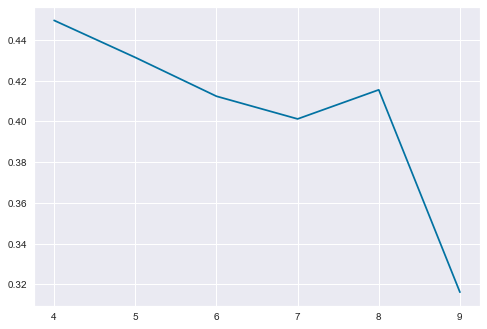

In [30]:
sil_score = []
cluster_list = list(range(4, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

- 8 clusters seems to be a reasonable choice here

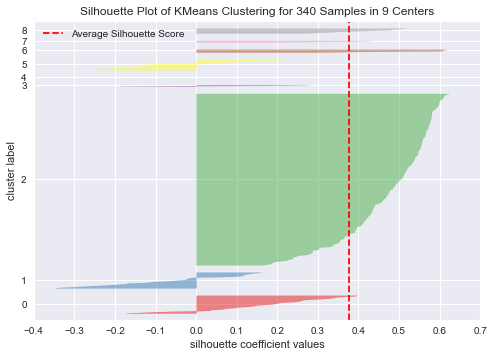

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 9 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [31]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(9, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

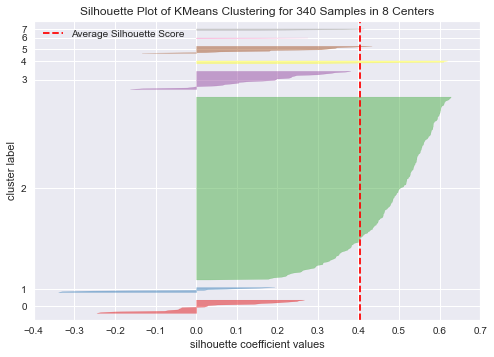

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [32]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(8, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

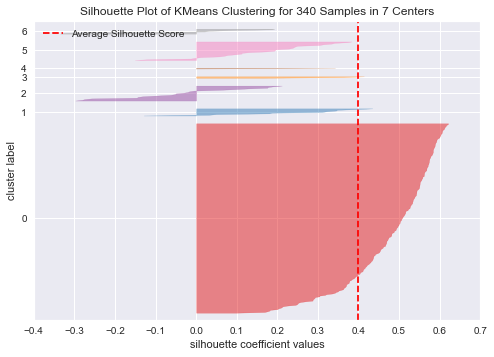

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [33]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

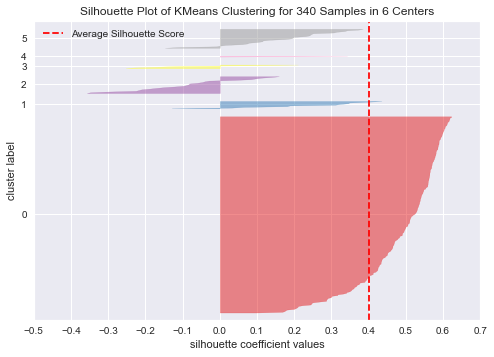

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [34]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

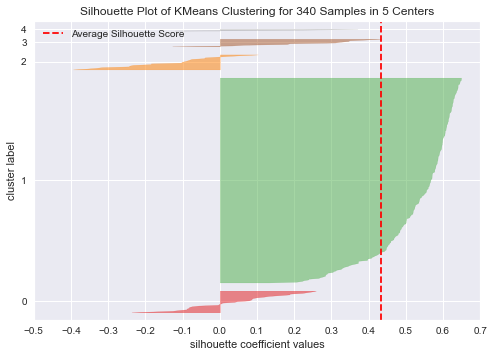

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [35]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

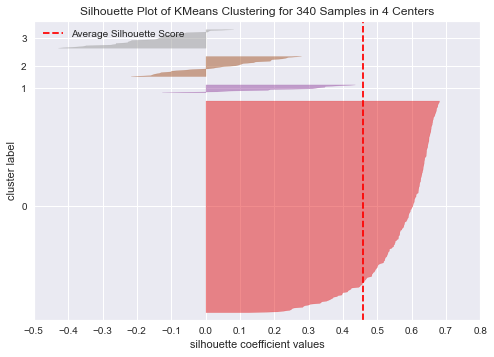

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [36]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

- We will choose 8 clusters for our K-means clustering model.

In [37]:
kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(random_state=0)

In [38]:
df1 = df.copy()
# adding kmeans cluster labels to the original dataframe
df1["K_means_segments"] = kmeans.labels_

#### KM Cluster Profiling

In [39]:
km_cluster_profile = df1.groupby("K_means_segments").mean()

In [40]:
km_cluster_profile["count_in_each_segment"] = (
    df1.groupby("K_means_segments")["Current_Price"].count().values
)

In [41]:
# let's display cluster profiles
km_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio,count_in_each_segment
K_means_segments,,,,,,,,,,,,
0,508.534992,5.732177,1.504640,27.250000,150.875000,37895875.000000,1116994125.000000,15.965000,75654420.935000,43.727459,29.581664,8
1,80.152167,14.571437,1.829679,28.100000,321.850000,625929050.000000,942050500.000000,2.010500,790456335.265000,45.067457,8.307945,20
2,71.419603,4.948894,1.373081,25.337121,51.272727,19976181.818182,1588185079.545455,3.719489,438021401.544886,23.214179,-3.335092,264
3,34.231808,-15.515565,2.832069,48.037037,47.740741,-128651518.518519,-2444318518.518518,-6.284444,503031539.057037,75.627265,1.655990,27
4,46.672222,5.166566,1.079367,25.000000,58.333333,-3040666666.666667,14848444444.444445,3.435556,4564959946.222222,15.596051,-6.354193,9
5,84.355716,3.854981,1.827670,633.571429,33.571429,-568400000.000000,-4968157142.857142,-10.841429,398169036.442857,42.284541,-11.589502,7
6,25.640000,11.237908,1.322355,12.500000,130.500000,16755500000.000000,13654000000.000000,3.295000,2791829362.100000,13.649696,1.508484,2
7,327.006671,21.917380,2.029752,4.000000,106.000000,698240666.666667,287547000.000000,0.750000,366763235.300000,400.989188,-5.322376,3


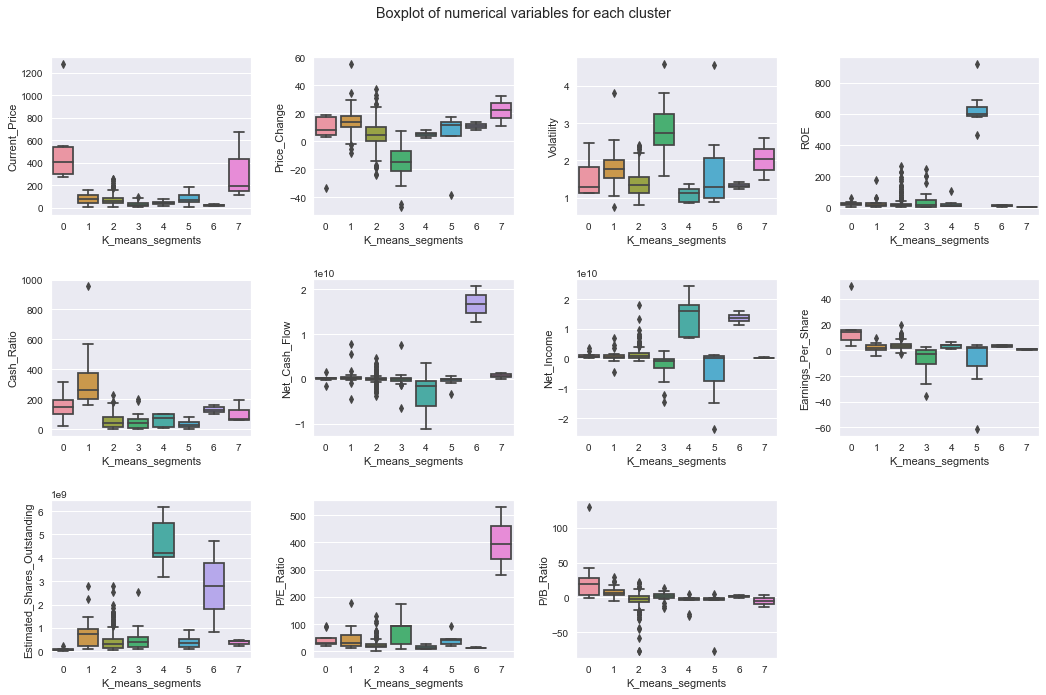

In [42]:
plt.figure(figsize=(15, 10))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(num_col):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df1, x="K_means_segments", y=variable)

plt.tight_layout(pad=2.0)

In [43]:
# let's see the names of the indexes in each cluster
for cl in df1["K_means_segments"].unique():
    print(
        "The",
        df1[df1["K_means_segments"] == cl]["Ticker_Symbol"].nunique(),
        "Index in cluster",
        cl,
        "are:",
    )
    print(df1[df1["K_means_segments"] == cl]["Ticker_Symbol"].unique())
    print("-" * 100, "\n")

The 264 Index in cluster 2 are:
['AAL', 'ABBV', 'ABT', 'ADM', 'AEE', ..., 'XYL', 'YUM', 'ZBH', 'ZION', 'ZTS']
Length: 264
Categories (340, object): ['AAL', 'ABBV', 'ABT', 'ADBE', ..., 'YUM', 'ZBH', 'ZION', 'ZTS']
---------------------------------------------------------------------------------------------------- 

The 20 Index in cluster 1 are:
['ADBE', 'ADI', 'AMGN', 'AVGO', 'CELG', ..., 'TRIP', 'VRTX', 'WAT', 'WYNN', 'YHOO']
Length: 20
Categories (340, object): ['AAL', 'ABBV', 'ABT', 'ADBE', ..., 'YUM', 'ZBH', 'ZION', 'ZTS']
---------------------------------------------------------------------------------------------------- 

The 8 Index in cluster 0 are:
['ADS', 'BIIB', 'CMG', 'EQIX', 'ISRG', 'MTD', 'PCLN', 'REGN']
Categories (340, object): ['AAL', 'ABBV', 'ABT', 'ADBE', ..., 'YUM', 'ZBH', 'ZION', 'ZTS']
---------------------------------------------------------------------------------------------------- 

The 7 Index in cluster 5 are:
['ALLE', 'APA', 'CHK', 'CHTR', 'CL', 'KMB', 'SPG

In [44]:
# let's see the sectors in each cluster
for cl in df1["K_means_segments"].unique():
    print(
        "The",
        df1[df1["K_means_segments"] == cl]["GICS_Sector"].nunique(),
        "Index in cluster",
        cl,
        "are:",
    )
    print(df1[df1["K_means_segments"] == cl]["GICS_Sector"].unique())
    print("-" * 100, "\n")

The 11 Index in cluster 2 are:
['Industrials', 'Health Care', 'Consumer Staples', 'Utilities', 'Financials', ..., 'Information Technology', 'Materials', 'Consumer Discretionary', 'Telecommunications Services', 'Energy']
Length: 11
Categories (11, object): ['Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', ..., 'Materials', 'Real Estate', 'Telecommunications Services', 'Utilities']
---------------------------------------------------------------------------------------------------- 

The 7 Index in cluster 1 are:
['Information Technology', 'Health Care', 'Telecommunications Services', 'Energy', 'Consumer Discretionary', 'Consumer Staples', 'Materials']
Categories (11, object): ['Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', ..., 'Materials', 'Real Estate', 'Telecommunications Services', 'Utilities']
---------------------------------------------------------------------------------------------------- 

The 4 Index in cluster 0 are:
['Information T

#### Observations:

**Cluster 0**
- This cluster has very high current price, earnings per share and P/B ratio.
- While it has considerably low volatility, ROE, estimated shares outstanding and P/E ratio.
- This maybe because of real estate sector.

**Cluster 1**
- 20 indexes are in this cluster.
- The cash ratio is very high in this cluster. All the mentioned sectors in our exploratory analysis before are in this cluster, namely IT, telecommunication service and health care sectors.
- The price change in this cluster is also considerably high.
- Moreover the stocks in this cluster is quite volatile.

**Cluster 2**
- This cluster seems to be the norm across all the features as there are 264 indexes in this cluster.

**Cluster 3**
- 27 indexes are in this cluster.
- Price change is the lowest in here.
- The net income and earnings per share is quite low as well.

**Cluster 4**
- This cluster has the lowest volatility and net cash flow.
- It has the highest net income and estimated shares outstanding.
- Consumer discretionary and consumer staples sector seems to be the contributing factor, very interesting to note for.

**Cluster 5**
- This has a considerably high price change and a very high ROE.
- It has low net income and earnings per share.

**Cluster 6**
- 2 indexes are in this cluster.
- This cluster has significant high cash ratio.
- This has a very high net cash flow, net income and estimated shares outstanding.
- Make sense since it is coming from financials and IT sectors.

**Cluster 7**
- 3 indexes are in this cluster.
- This cluster has a high current price, price change, volatility and P/E ratio.

## Hierarchical Clustering

In [45]:
HC_df = subset_scaled_df.copy()

In [46]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(HC_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(HC_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9232271494002922.
Cophenetic correlation for Euclidean distance and complete linkage is 0.7873280186580672.
Cophenetic correlation for Euclidean distance and average linkage is 0.9422540609560814.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8693784298129404.
Cophenetic correlation for Chebyshev distance and single linkage is 0.9062538164750717.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.598891419111242.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9338265528030499.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9127355892367.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9259195530524588.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.792530720285.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9247324030159736.
Cophenetic correlatio

- single and average linkage works well for each distance metrics rexpectively.

In [47]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9422540609560814, which is obtained with Euclidean distance and average linkage.


**Euclidean distance**

In [48]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(HC_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(HC_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.9232271494002922.
Cophenetic correlation for complete linkage is 0.7873280186580672.
Cophenetic correlation for average linkage is 0.9422540609560814.
Cophenetic correlation for centroid linkage is 0.9314012446828154.
Cophenetic correlation for ward linkage is 0.7101180299865353.
Cophenetic correlation for weighted linkage is 0.8693784298129404.


In [49]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9422540609560814, which is obtained with average linkage.


We look at more linkage methods for euclidean metric.

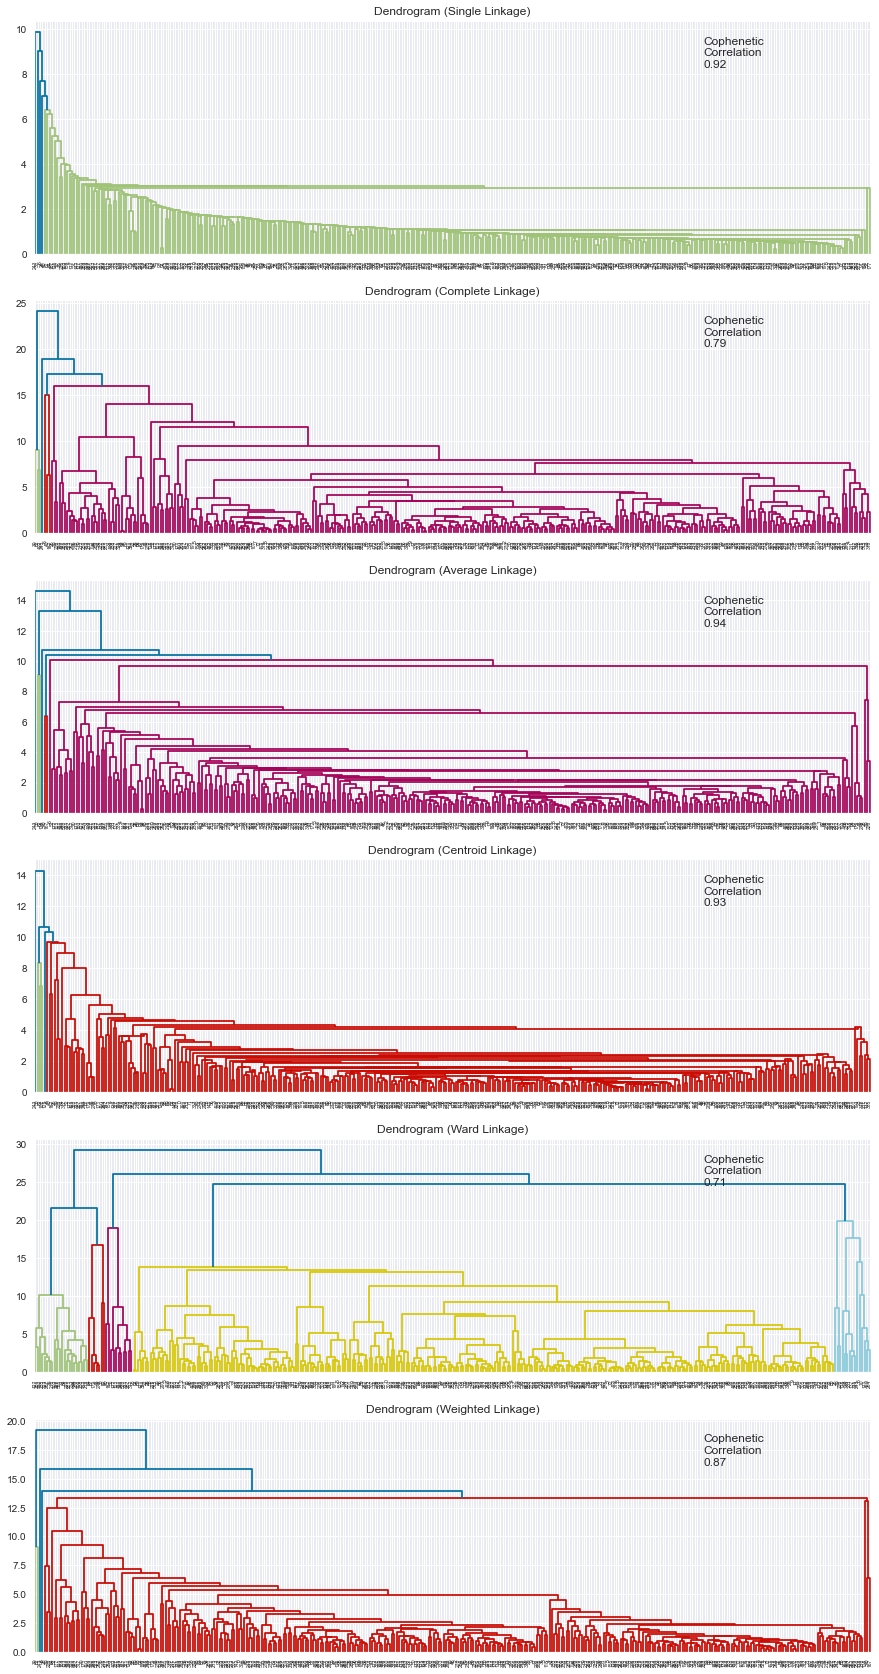

In [50]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(HC_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(HC_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

- Looking at the average linkage dendrogram, 8 seems to be the choice of our number of clusters.

Let's look at other distance metrics with single and average linkage methods

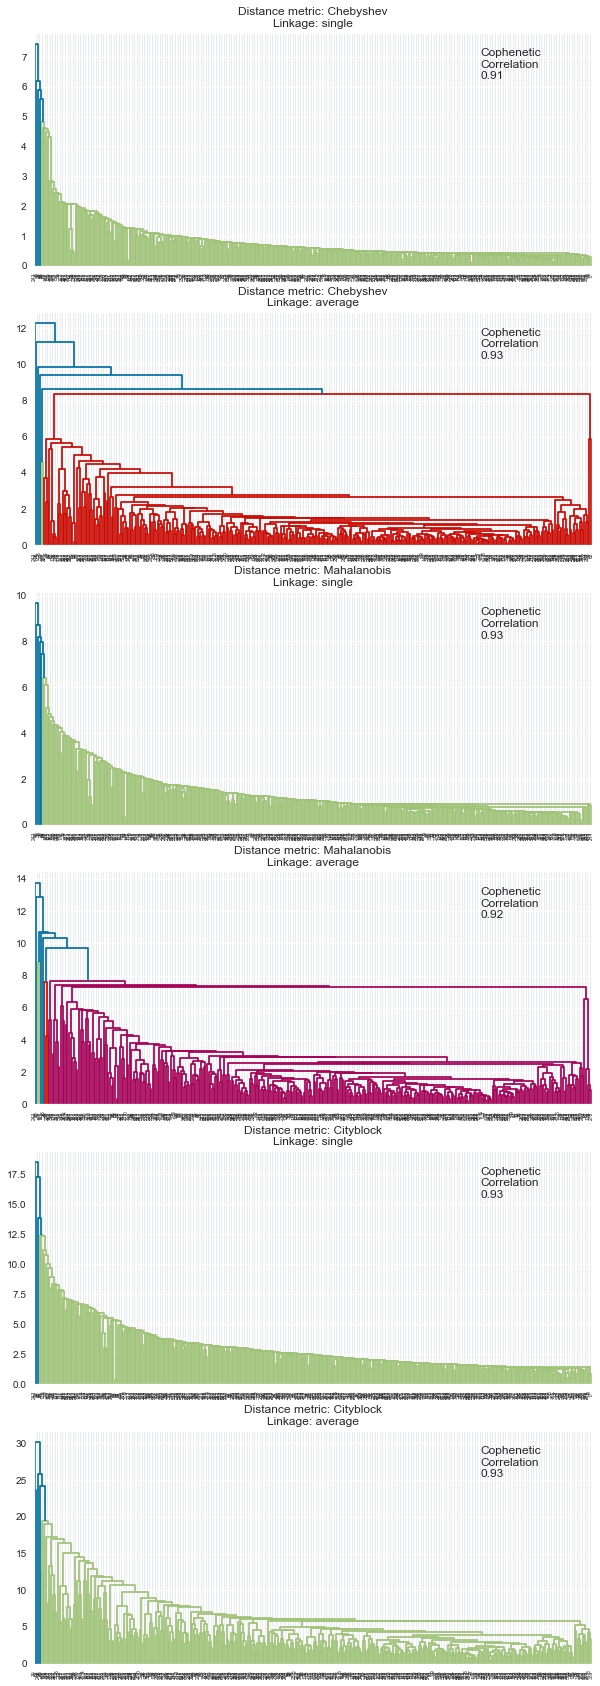

In [51]:
# list of distance metrics
distance_metrics = ["chebyshev","mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "average"]

# to create a subplot image
fig, axs = plt.subplots(
    len(distance_metrics) + len(distance_metrics), 1, figsize=(10, 30)
)

i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(HC_df, metric=dm, method=lm)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title("Distance metric: {}\nLinkage: {}".format(dm.capitalize(), lm))

        coph_corr, coph_dist = cophenet(Z, pdist(HC_df))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )
        i += 1

- Overally, 8 seems to be the right choice.

We will choose our model to have average linkage of euclidean distance metric with 8 clusters.

In [52]:
HCmodel = AgglomerativeClustering(n_clusters=8, affinity="euclidean", linkage="average")
HCmodel.fit(HC_df)

AgglomerativeClustering(linkage='average', n_clusters=8)

In [53]:
df2 = df.copy()
# adding hierarchical cluster labels to the original and scaled dataframes

HC_df["HC_Clusters"] = HCmodel.labels_
df2["HC_Clusters"] = HCmodel.labels_

#### Agglomerative Cluster Profiling

In [54]:
HC_cluster_profile = df2.groupby("HC_Clusters").mean()

In [55]:
# let's see the names of the indexes in each cluster
for cl in df2["HC_Clusters"].unique():
    print(
        "The",
        df2[df2["HC_Clusters"] == cl]["Ticker_Symbol"].nunique(),
        "Index in cluster",
        cl,
        "are:",
    )
    print(df2[df2["HC_Clusters"] == cl]["Ticker_Symbol"].unique())
    print("-" * 100, "\n")

The 330 Index in cluster 2 are:
['AAL', 'ABBV', 'ABT', 'ADBE', 'ADI', ..., 'YHOO', 'YUM', 'ZBH', 'ZION', 'ZTS']
Length: 330
Categories (340, object): ['AAL', 'ABBV', 'ABT', 'ADBE', ..., 'YUM', 'ZBH', 'ZION', 'ZTS']
---------------------------------------------------------------------------------------------------- 

The 1 Index in cluster 5 are:
['ADS']
Categories (340, object): ['AAL', 'ABBV', 'ABT', 'ADBE', ..., 'YUM', 'ZBH', 'ZION', 'ZTS']
---------------------------------------------------------------------------------------------------- 

The 3 Index in cluster 0 are:
['ALXN', 'AMZN', 'NFLX']
Categories (340, object): ['AAL', 'ABBV', 'ABT', 'ADBE', ..., 'YUM', 'ZBH', 'ZION', 'ZTS']
---------------------------------------------------------------------------------------------------- 

The 1 Index in cluster 7 are:
['APA']
Categories (340, object): ['AAL', 'ABBV', 'ABT', 'ADBE', ..., 'YUM', 'ZBH', 'ZION', 'ZTS']
------------------------------------------------------------------------

In [56]:
HC_cluster_profile["count_in_each_segments"] = (
    df2.groupby("HC_Clusters")["Current_Price"].count().values
)

In [57]:
# let's display cluster profiles
HC_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio,count_in_each_segments
HC_Clusters,,,,,,,,,,,,
0,327.006671,21.917380,2.029752,4.000000,106.000000,698240666.666667,287547000.000000,0.750000,366763235.300000,400.989188,-5.322376,3
1,25.640000,11.237908,1.322355,12.500000,130.500000,16755500000.000000,13654000000.000000,3.295000,2791829362.100000,13.649696,1.508484,2
2,75.017416,3.937751,1.513415,35.621212,66.545455,-39846757.575758,1549443100.000000,2.904682,562266326.402576,29.091275,-2.146308,330
3,104.660004,16.224320,1.320606,8.000000,958.000000,592000000.000000,3669000000.000000,1.310000,2800763359.000000,79.893133,5.884467,1
4,1274.949951,3.190527,1.268340,29.000000,184.000000,-1671386000.000000,2551360000.000000,50.090000,50935516.070000,25.453183,-1.052429,1
5,276.570007,6.189286,1.116976,30.000000,25.000000,90885000.000000,596541000.000000,8.910000,66951851.850000,31.040405,129.064585,1
6,4.500000,-38.101788,4.559815,687.000000,22.000000,-3283000000.000000,-14685000000.000000,-22.430000,654703522.100000,28.407929,-1.840528,1
7,44.470001,11.397804,2.405408,917.000000,80.000000,698000000.000000,-23528000000.000000,-61.200000,384444444.400000,93.089287,4.970809,1


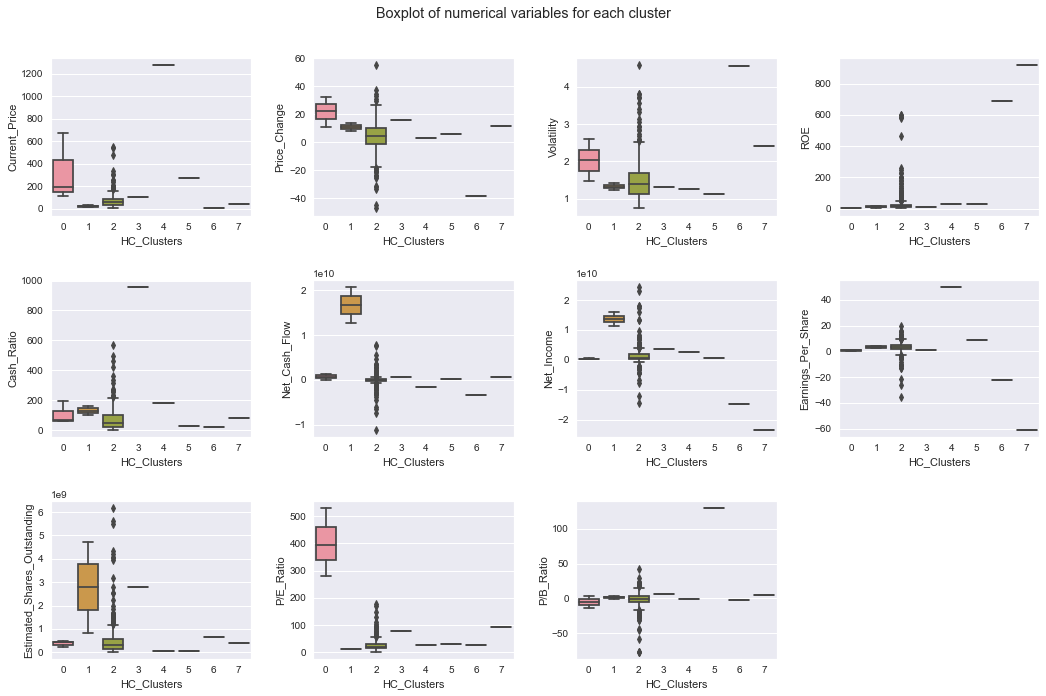

In [58]:
plt.figure(figsize=(15, 10))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(num_col):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df2, x="HC_Clusters", y=variable)

plt.tight_layout(pad=2.0)

In [59]:
pd.crosstab(df2.HC_Clusters, df2.GICS_Sector).style.highlight_max(color="lightgreen", axis=0)

GICS_Sector,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Telecommunications Services,Utilities
HC_Clusters,,,,,,,,,,,
0,1,0,0,0,1,0,1,0,0,0,0
1,0,0,0,1,0,0,1,0,0,0,0
2,38,19,28,48,39,53,29,20,27,5,24
3,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0
6,0,0,1,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,0


#### Observations:

**Cluster 0**
- This cluster has 3 indexes from 3 different sectors, which are notably Alexion Pharm, Amazon and Netflix.
- It has considerably high current price and volatility. 
- It has very high price change and P/E ratio.

**Cluster 1**
- Bank of America and Intel are in this cluster.
- They have high net cash flow, net income and estimated shares outstanding.
- Special note that there is a lot of outliers across the features, this maybe due to the nature of the bank.

**Cluster 2**
- Yet again, this cluster seems to be the norm among all, 330 indexes are in this cluster.

**Cluster 3**
- PCLN belongs to this cluster and it has the highest current price and earnings per share among all clusters.

**Cluster 4**
- This cluster which belongs to FB has very high cash ratio and estimated shares outstanding.

**Cluster 5**
- CHK has very low current price, price change, cash ratio and P/B ratio.
- While it has a very high volatility and ROE.

**Cluster 6**
- Addidas has very high P/B ratio among other clusters.

**Cluster 7**
- APA has the highest ROE but lowest net income and earnings per share.

## K-means vs Hierarchical Clustering

- Hierarchical clustering took time in plotting the dendrograms as expected.
- In our case, K-means clustering gave more distinct clusters.
- In both our algorithm, each clusters has at least one interesting observation.
- Overall, 8 clusters were the ideal choice for both cluster profiling

Similarities and differences:
- It seems that cluster 2 in both algorithms shares similar properties.
- Cluster 7 in K-means is the exact same as Cluster 0 in our agglomerative clustering.
- Also,  Cluster 6 from K-means is the exact same as Cluster 1 in our agglomerative clustering.
- While the rest of the clusters in each algorithms respectively captures different features.

## Actionable Insights and Recommendations

In this analysis, K-means clustering seems to perform better in clustering. Hence insights and recommendation will be drawn based from it.

#### Actionable Insights:
- The notable clusters are Cluster 0, Cluster 4, Cluster 6 and Cluster 7.
- These mentioned clusters are in fact the popular indexes in the financial market, especially Addidas, Amazon, Netflix and Bank of America.
- High risk high return indexes are in Cluster 7, so risk-lovers investors maybe interested here.
- For risk-adverse investors, indexes in Cluster 0 and Cluster 4 can be considered in your portfolio.
- That being said, Cluster 2 can still be considered but for diversification strategy purposes.


### Dimension Reduction Technique for Visualization

#### PCA

In [60]:
pca_df = subset_scaled_df.copy()

In [61]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(pca_df)

In [62]:
pca_df = pd.DataFrame(
    data=pca_data, columns=["Principal Component 1",
                            "Principal Component 2", ]
#                             "Principal Component 3",
#                             "Principal Component 4", 
#                             "Principal Component 5", 
#                             "Principal Component 6"]
)
pca_df.tail()

,Principal Component 1,Principal Component 2
335,0.860894,1.453357
336,0.651640,-0.689641
337,0.505446,0.824131
338,0.353286,-0.152693
339,0.315878,0.470818


In [63]:
print(
    "Explained variance per principal component: {}".format(
        pca.explained_variance_ratio_
    )
)

Explained variance per principal component: [0.22770322 0.14358674]


In [64]:
# defining the targets
targets = list(df.GICS_Sector.unique())
targets

['Industrials',
 'Health Care',
 'Information Technology',
 'Consumer Staples',
 'Utilities',
 'Financials',
 'Real Estate',
 'Materials',
 'Consumer Discretionary',
 'Energy',
 'Telecommunications Services']

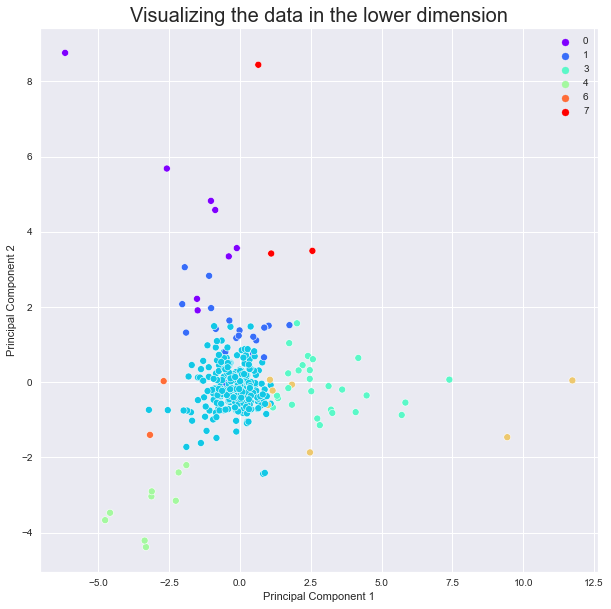

In [65]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=pca_df, x="Principal Component 1", y="Principal Component 2", hue=df1["K_means_segments"],
    palette="rainbow"
)
plt.legend(bbox_to_anchor=(1, 1))
plt.title("Visualizing the data in the lower dimension", fontsize=20)
plt.show()

#### t-SNE

In [66]:
tsne_df = subset_scaled_df.copy()

In [67]:
tsne = TSNE(n_components=2, random_state=1)
tsne_data = tsne.fit_transform(tsne_df)

In [68]:
tsne_df = pd.DataFrame(data=tsne_data, columns=["Component 1", "Component 2"])
tsne_df.tail()

,Component 1,Component 2
335,10.832344,9.559889
336,-16.298714,3.012274
337,-9.177835,-9.452691
338,1.227342,0.855794
339,-2.591636,-4.179144


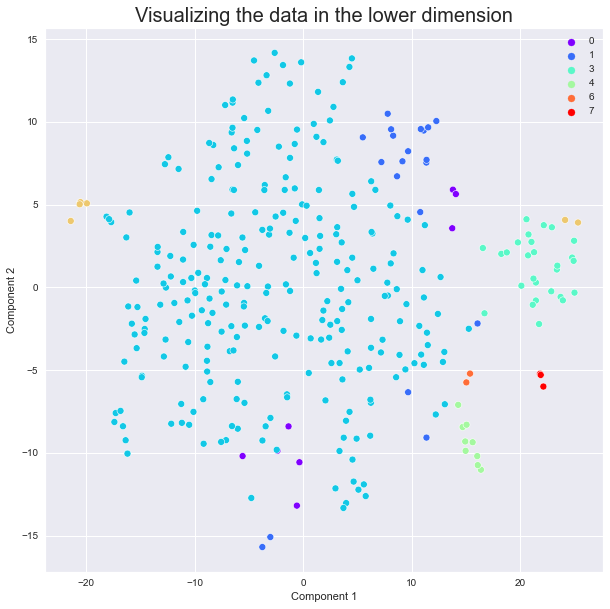

In [69]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=tsne_df, x="Component 1", y="Component 2", hue=df1["K_means_segments"],
    palette="rainbow")
plt.legend(bbox_to_anchor=(1, 1))
plt.title("Visualizing the data in the lower dimension", fontsize=20)
plt.show()

Visualizing the lower dimensional representation of data for different values of perplexity


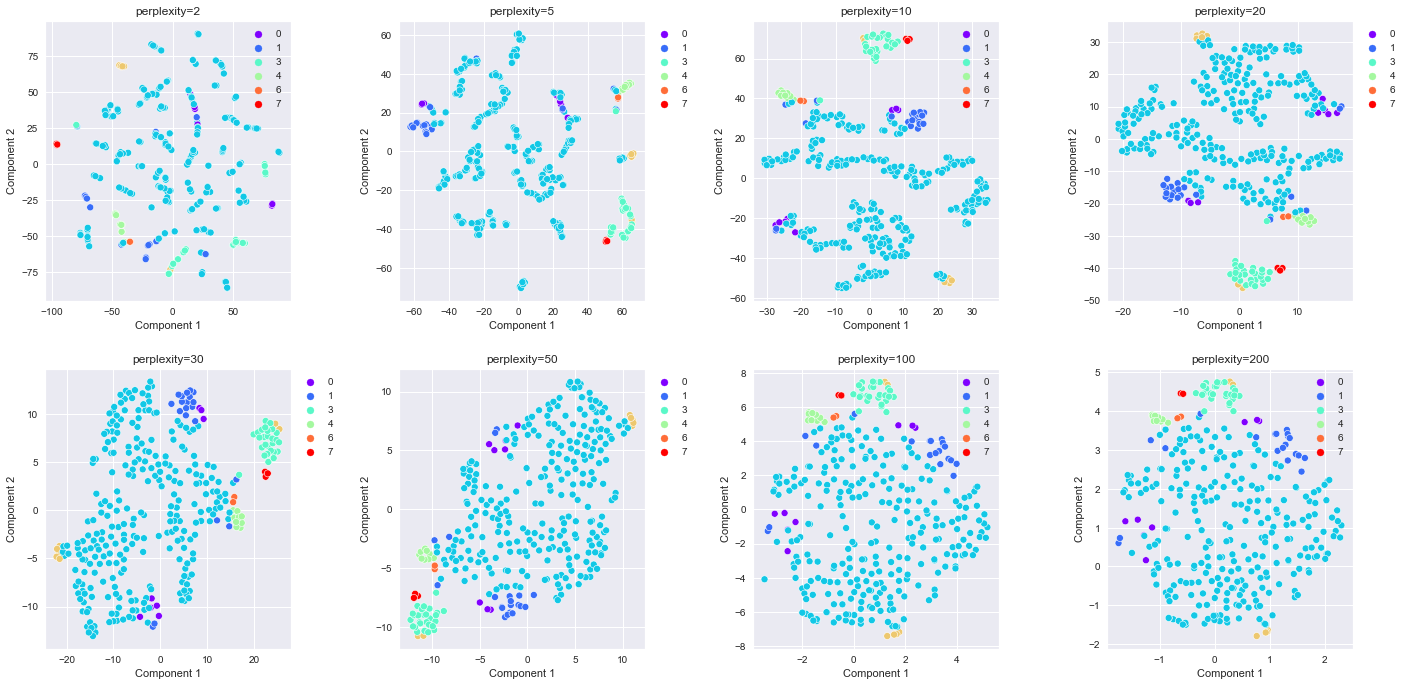

In [70]:
perplexity = [2, 5, 10, 20, 30, 50, 100, 200]

plt.figure(figsize=(20, 10))
print(
    "Visualizing the lower dimensional representation of data for different values of perplexity"
)

for i in range(len(perplexity)):
    tsne = TSNE(n_components=2, perplexity=perplexity[i], n_jobs=-2, random_state=1)
    # n_jobs specifies the number of parallel jobs to run
    # -2 means using all processors except one
    X_red = tsne.fit_transform(tsne_df)

    red_data_df = pd.DataFrame(data=X_red, columns=["Component 1", "Component 2"])

    plt.subplot(2, int(len(perplexity) / 2), i + 1)

    plt.title("perplexity=" + str(perplexity[i]))
    sns.scatterplot(data=red_data_df, x="Component 1", y="Component 2", hue=df1["K_means_segments"],
    palette="rainbow")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout(pad=2)